In [1]:
import torch
import torchinfo
import clip  # Import CLIP library
from torch.utils.data import DataLoader

from level_1_dataloader import image_dataloader
from level_1_classifier_1 import level_1_classifier, level_1_model, level_1_output_layer
from level_2_classifier import level_2_classifier, level_2_output_layer, level_2_pre_model_concate, level_2_post_model
from Trainer_1 import Trainer_level_1, Trainer_level_2
from Tester_1 import Tester_level_1, Tester_level_2

import copy

In [2]:
train_set = image_dataloader(csv_file='train_set.xls', root_dir='coverpage/coverpage/')
val_set = image_dataloader(csv_file='val_set.xls', root_dir='coverpage/coverpage/')
test_set = image_dataloader(csv_file='test_set.xls', root_dir='coverpage/coverpage/')


In [3]:
print('no. of training sample', len(train_set))
print('no. of validation sample', len(val_set))
print('no. of testing sample', len(test_set))



no. of training sample 22340
no. of validation sample 2804
no. of testing sample 2809


In [4]:
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [5]:
import torch
from transformers import BlipModel
from torchinfo import summary

class VisionOnlyModel(torch.nn.Module):
    def __init__(self, vision_model):
        super(VisionOnlyModel, self).__init__()
        self.vision_model = vision_model

    def forward(self, pixel_values):
        # Extract the class token (first token) from the last hidden state
        outputs = self.vision_model(pixel_values=pixel_values).last_hidden_state
        class_token_output = outputs[:, 0, :]  # Take the first token
        return class_token_output

def fine_tune_load_image_model():
    # Load the pre-trained BLIP model
    blip_model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base")

    # Extract the vision model
    vision_model = blip_model.vision_model

    # Wrap it in a new model class
    vision_only_model = VisionOnlyModel(vision_model)

    # Enable gradients for the image model's parameters
    for p in vision_only_model.parameters():
        p.requires_grad = True

    return vision_only_model

In [6]:
vision_model = fine_tune_load_image_model()

Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.encoder.layer.0.attention.self.value.bias', 'text_model.encoder.layer.0.attention.self.value.weight', 'text_model.encoder.layer.0.crossattention.output.LayerNorm.bias', 'text_model.

In [7]:
summary(
    vision_model, 
    input_size=(1, 3, 224, 224), 
    col_names=('input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'), 
    verbose=1
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
VisionOnlyModel                                         [1, 3, 224, 224]          [1, 768]                  --                        --                        --
├─BlipVisionModel: 1-1                                  --                        [1, 768]                  --                        --                        --
│    └─BlipVisionEmbeddings: 2-1                        [1, 3, 224, 224]          [1, 197, 768]             443,904                   --                        --
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   [16, 16]                  115,756,032
│    └─BlipEncoder: 2-2                                 --                        [1, 197, 768]             --                        --                        --
│    │

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
VisionOnlyModel                                         [1, 3, 224, 224]          [1, 768]                  --                        --                        --
├─BlipVisionModel: 1-1                                  --                        [1, 768]                  --                        --                        --
│    └─BlipVisionEmbeddings: 2-1                        [1, 3, 224, 224]          [1, 197, 768]             443,904                   --                        --
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   [16, 16]                  115,756,032
│    └─BlipEncoder: 2-2                                 --                        [1, 197, 768]             --                        --                        --
│    │

In [8]:
import torch
from transformers import BlipModel
from torchinfo import summary

class VisionOnlyModel(torch.nn.Module):
    def __init__(self, vision_model):
        super(VisionOnlyModel, self).__init__()
        self.vision_model = vision_model

    def forward(self, pixel_values):
        # Extract the class token (first token) from the last hidden state
        outputs = self.vision_model(pixel_values=pixel_values).last_hidden_state
        class_token_output = outputs[:, 0, :]  # Take the first token
        return class_token_output

def fine_tune_load_image_model():
    # Load the pre-trained BLIP model
    blip_model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base")

    # Extract the vision model
    vision_model = blip_model.vision_model

    # Wrap it in a new model class
    vision_only_model = VisionOnlyModel(vision_model)

    # Enable gradients for the image model's parameters
    for p in vision_only_model.parameters():
        p.requires_grad = True

    return vision_only_model

# Example usage:
vision_model = fine_tune_load_image_model()

Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.encoder.layer.0.attention.self.value.bias', 'text_model.encoder.layer.0.attention.self.value.weight', 'text_model.encoder.layer.0.crossattention.output.LayerNorm.bias', 'text_model.

In [10]:
FE_model = fine_tune_load_image_model()
print(FE_model)

Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.encoder.layer.0.attention.self.value.bias', 'text_model.encoder.layer.0.attention.self.value.weight', 'text_model.encoder.layer.0.crossattention.output.LayerNorm.bias', 'text_model.

VisionOnlyModel(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, elementwis

In [12]:
import os

used_model = 'BLIP'
used_model_feature_size = 768
level_1_checkpoint_dir = './checkpoints/' + used_model + '/level_1/'
level_1_model_file = 'model.pth'
level_1_csvlogger_file = 'log.csv'
level_1_weights_path = os.path.join(level_1_checkpoint_dir, level_1_model_file)
feature_size_extract_from_level_1 = 64
no_epoch = 10
lr = 0.00001
optimizer = 'AdamW'

# Create the directory if it doesn't exist
os.makedirs(level_1_checkpoint_dir, exist_ok=True)

# Print a message to confirm the directory creation (optional)
print(f"Directory {level_1_checkpoint_dir} is ready.")

Directory ./checkpoints/BLIP/level_1/ is ready.


In [13]:
used_model_feature_size = 768  # Example value, adjust based on your model
feature_size_extract_from_level_1 = 768 

In [14]:
# Define and prepare model components
classifier_level_1 = level_1_classifier(feature_size=used_model_feature_size, feature_size_extract_from_level_1=feature_size_extract_from_level_1)
output_layer_level_1 = level_1_output_layer(feature_size_extract_from_level_1=feature_size_extract_from_level_1, no_class=2)
model_level_1 = level_1_model(FE_model, classifier_level_1, output_layer_level_1)

In [15]:
torchinfo.summary(model_level_1, (1, 3, 224, 224), col_names=('input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'), verbose=1)


Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
level_1_model                                                [1, 3, 224, 224]          [1, 2]                    --                        --                        --
├─VisionOnlyModel: 1-1                                       [1, 3, 224, 224]          [1, 768]                  --                        --                        --
│    └─BlipVisionModel: 2-1                                  --                        [1, 768]                  --                        --                        --
│    │    └─BlipVisionEmbeddings: 3-1                        [1, 3, 224, 224]          [1, 197, 768]             1,034,496                 --                        115,756,032
│    │    └─BlipEncoder: 3-2                                 --                        [1, 197, 768]             85,054,464                --   

/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
level_1_model                                                [1, 3, 224, 224]          [1, 2]                    --                        --                        --
├─VisionOnlyModel: 1-1                                       [1, 3, 224, 224]          [1, 768]                  --                        --                        --
│    └─BlipVisionModel: 2-1                                  --                        [1, 768]                  --                        --                        --
│    │    └─BlipVisionEmbeddings: 3-1                        [1, 3, 224, 224]          [1, 197, 768]             1,034,496                 --                        115,756,032
│    │    └─BlipEncoder: 3-2                                 --                        [1, 197, 768]             85,054,464                --   

In [29]:
trainer = Trainer_level_1(model = model_level_1, level=1, training_dataloader = train_dataloader, validation_dataloader = val_dataloader, epoch = no_epoch, learning_rate = lr, use_gpu = True, opt_method = optimizer, checkpoint_dir = level_1_checkpoint_dir, checkpoint_filename=level_1_model_file, csv_logger = level_1_csvlogger_file  )

Finish initializing...
2024-06-08 17:49:06.268102
EPOCH 1:


100%|████████████████████████| 699/699 [1:30:22<00:00,  7.76s/batch, loss=0.194]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.5657635028653902, train_precision_0.7254789585721303, train_recall_0.7596228032576082, train_f1 0.7421583818417855, train_acc_0.724395702775291, train_ba_0.7227622213009353, train_spec_0.6859016393442623, train_hm_0.275604297224709, val_loss 0.4518546164035797, val_precision_0.8458755426917511, val_recall_0.759090909090909, val_f1 0.8001368925393565, val_acc_0.7917261055634808, val_ba_0.7952891254315304, val_spec_0.8314873417721519, val_hm_0.20827389443651925
2024-06-08 19:23:27.596337
EPOCH 2:


  0%|                                                | 0/699 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|███████████████████████| 699/699 [1:30:16<00:00,  7.75s/batch, loss=0.0584]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.34128084896033756, train_precision_0.8636556583750743, train_recall_0.8720960137162452, train_f1 0.8678553147926975, train_acc_0.8613249776186213, train_ba_0.8608255244225254, train_spec_0.8495550351288056, train_hm_0.1386750223813787, val_loss 0.3741685748100281, val_precision_0.8035030103995622, val_recall_0.9532467532467532, val_f1 0.871992871992872, val_acc_0.8462910128388017, val_ba_0.8346138829524905, val_spec_0.7159810126582279, val_hm_0.1537089871611983
2024-06-08 20:57:43.250330
EPOCH 3:


  0%|                                                | 0/699 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|████████████████████████| 699/699 [1:30:30<00:00,  7.77s/batch, loss=0.349]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.1787704483436711, train_precision_0.9353301565690946, train_recall_0.9423060437205315, train_f1 0.9388051415638212, train_acc_0.9358549686660699, train_ba_0.9355558321647154, train_spec_0.9288056206088993, train_hm_0.06414503133393017, val_loss 0.3614661395549774, val_precision_0.8769736842105263, val_recall_0.8655844155844156, val_f1 0.8712418300653595, val_acc_0.8594864479315264, val_ba_0.858820688804866, val_spec_0.8520569620253164, val_hm_0.1405135520684736
2024-06-08 22:32:14.503198
EPOCH 4:


  0%|                                                | 0/699 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|████████████████████████| 699/699 [1:30:42<00:00,  7.79s/batch, loss=0.194]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.08983883654661423, train_precision_0.9719274221157138, train_recall_0.9735105015002143, train_f1 0.9727183177009722, train_acc_0.9714861235452104, train_ba_0.9713922530920276, train_spec_0.9692740046838407, train_hm_0.028513876454789616, val_loss 0.4403149485588074, val_precision_0.8066630256690334, val_recall_0.9590909090909091, val_f1 0.8762978344704835, val_acc_0.8512838801711841, val_ba_0.8395138089758343, val_spec_0.7199367088607594, val_hm_0.14871611982881597
2024-06-09 00:06:54.831547
EPOCH 5:


  0%|                                                | 0/699 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|███████████████████████| 699/699 [1:30:21<00:00,  7.76s/batch, loss=0.0304]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.05613244751545578, train_precision_0.9824155086635786, train_recall_0.9818259751393056, train_f1 0.9821206534322342, train_acc_0.9813339301700985, train_ba_0.981311114033353, train_spec_0.9807962529274005, train_hm_0.018666069829901523, val_loss 0.4444551467895508, val_precision_0.8551599275799638, val_recall_0.9201298701298701, val_f1 0.886456052549265, val_acc_0.8705420827389444, val_ba_0.8651282262041755, val_spec_0.810126582278481, val_hm_0.12945791726105563
2024-06-09 01:41:13.536345
EPOCH 6:


  0%|                                                | 0/699 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████████████████| 699/699 [1:30:22<00:00,  7.76s/batch, loss=0.00968]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.037420930476121085, train_precision_0.9875845534720439, train_recall_0.9887698242606087, train_f1 0.9881768334475669, train_acc_0.987645478961504, train_ba_0.9875933430436532, train_spec_0.9864168618266979, train_hm_0.01235452103849597, val_loss 0.4589522182941437, val_precision_0.8796758104738155, val_recall_0.9162337662337663, val_f1 0.8975826972010179, val_acc_0.8851640513552068, val_ba_0.8817719464080224, val_spec_0.8473101265822784, val_hm_0.11483594864479316
2024-06-09 03:15:33.904925
EPOCH 7:


  0%|                                                | 0/699 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|█████████████████████| 699/699 [1:30:19<00:00,  7.75s/batch, loss=0.000589]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.03151927686798372, train_precision_0.989454732510288, train_recall_0.989369909987141, train_f1 0.9894123194307515, train_acc_0.9889435989256938, train_ba_0.9889238308717907, train_spec_0.9884777517564403, train_hm_0.011056401074306178, val_loss 0.44884100556373596, val_precision_0.8659286592865929, val_recall_0.9142857142857143, val_f1 0.8894504106127606, val_acc_0.8751783166904422, val_ba_0.8709086799276673, val_spec_0.8275316455696202, val_hm_0.12482168330955777
2024-06-09 04:49:50.756996
EPOCH 8:


  0%|                                                | 0/699 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████████████████| 699/699 [1:30:18<00:00,  7.75s/batch, loss=0.00836]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.034303869928064445, train_precision_0.9890288848890032, train_recall_0.9891984569224175, train_f1 0.9891136636379222, train_acc_0.9886302596239929, train_ba_0.9886039123019581, train_spec_0.9880093676814988, train_hm_0.011369740376007163, val_loss 0.4572751820087433, val_precision_0.8941176470588236, val_recall_0.8883116883116883, val_f1 0.8912052117263843, val_acc_0.8808844507845934, val_ba_0.8800735656748315, val_spec_0.8718354430379747, val_hm_0.11911554921540657
2024-06-09 06:24:06.983038
EPOCH 9:


  0%|                                                | 0/699 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|█████████████████████| 699/699 [1:30:15<00:00,  7.75s/batch, loss=0.000739]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.023755750236569773, train_precision_0.9922918807810894, train_recall_0.9932276039434205, train_f1 0.992759521871385, train_acc_0.9924350940017905, train_ba_0.9923983452972371, train_spec_0.9915690866510538, train_hm_0.00756490599820949, val_loss 0.49500367045402527, val_precision_0.8899082568807339, val_recall_0.8818181818181818, val_f1 0.8858447488584476, val_acc_0.8751783166904422, val_ba_0.8744533947065593, val_spec_0.8670886075949367, val_hm_0.12482168330955777
2024-06-09 07:58:19.909247
EPOCH 10:


  0%|                                                | 0/699 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|█████████████████████| 699/699 [1:30:21<00:00,  7.76s/batch, loss=0.000729]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


LOSS train 0.02303444948195625, train_precision_0.9922852734441968, train_recall_0.9923703386198028, train_f1 0.9923278042089924, train_acc_0.991987466427932, train_ba_0.9919697126354283, train_spec_0.9915690866510538, train_hm_0.00801253357206804, val_loss 0.517383337020874, val_precision_0.8991373589913736, val_recall_0.8798701298701299, val_f1 0.8893994092550049, val_acc_0.8798145506419401, val_ba_0.879808482656584, val_spec_0.879746835443038, val_hm_0.12018544935805991


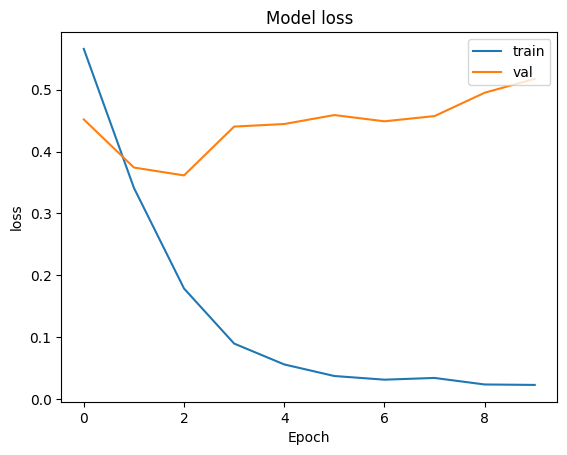

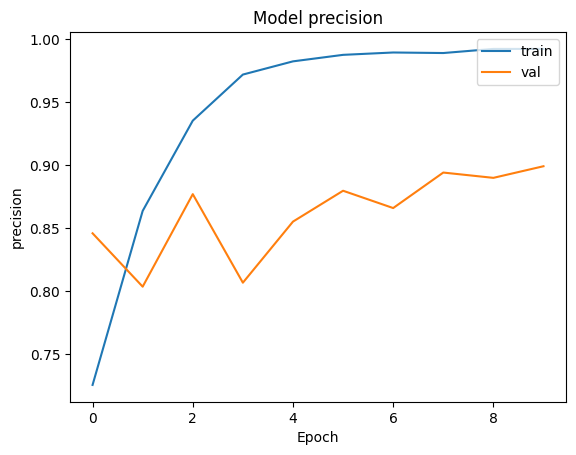

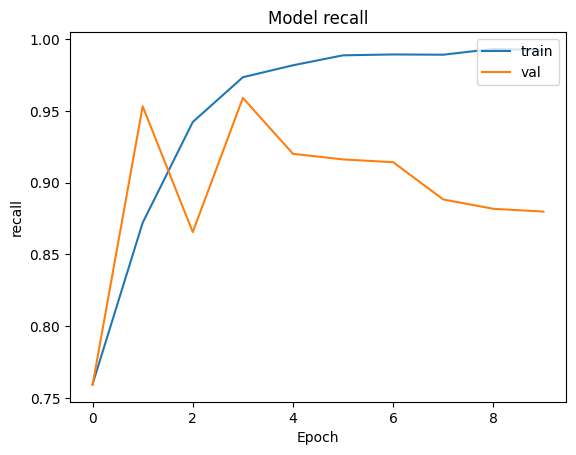

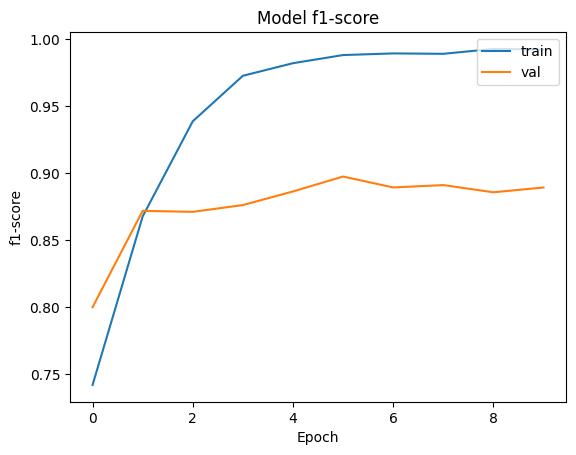

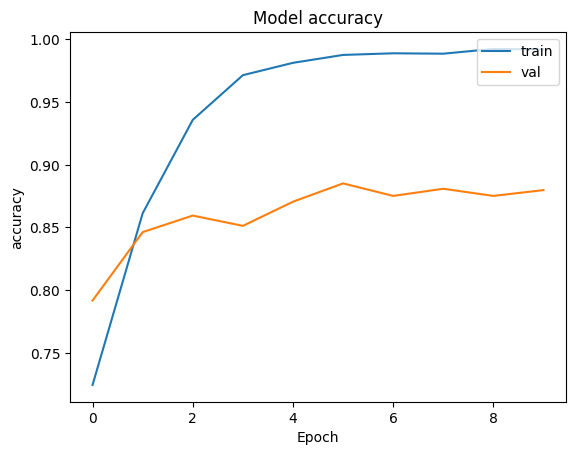

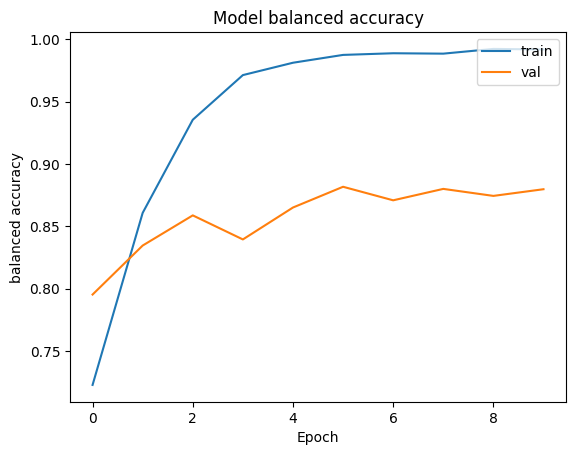

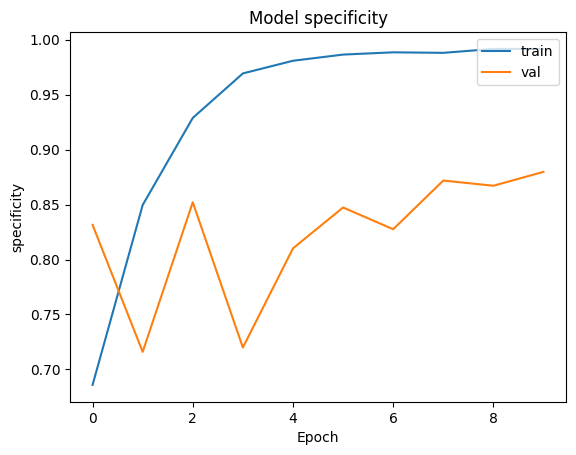

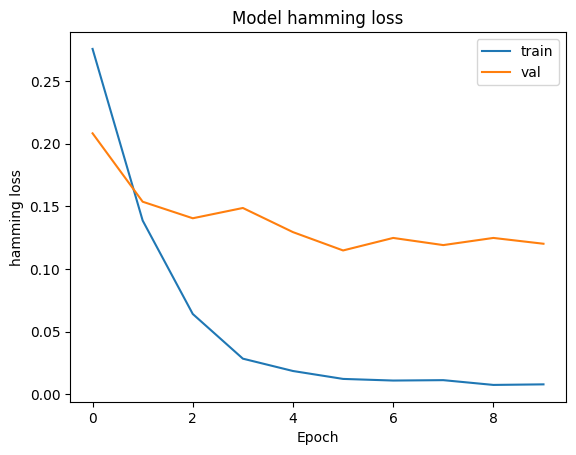

In [31]:
trainer.run()

In [32]:
tester = Tester_level_1(model = model_level_1, weights_file = level_1_model_file, level =1,  data_loader = test_dataloader, checkpoint_dir = level_1_checkpoint_dir)

weights are loaded


In [33]:
tester.prediction()

started prediction
2024-06-09 09:32:40.259013


  0%|                                                 | 0/88 [00:00<?, ?batch/s]/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|████████████████████████████| 88/88 [03:59<00:00,  2.72s/batch, loss=0.101]

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
LOSS test 0.3649510443210602, test_precision 0.8730366492146597, test_recall 0.8634304207119741, test_f1 0.8682069638789456, test_accuracy 0.8558205767176932, test_BA 0.8549747040268731, test_specificity 0.8465189873417721, test_hamming_loss 0.14417942328230687


In [16]:
no_epoch = 10
lr = 0.001
optimizer = 'AdamW'
# Define the base checkpoint directory
level_2_checkpoint_dir = './checkpoints/' + used_model + '/level_2_'

# Create directories for fiction and non-fiction checkpoints
fiction_checkpoint_dir = os.path.join(level_2_checkpoint_dir, 'fiction')
non_fiction_checkpoint_dir = os.path.join(level_2_checkpoint_dir, 'non_fiction')

# Ensure directories exist (avoid errors if not created beforehand)
os.makedirs(fiction_checkpoint_dir, exist_ok=True)
os.makedirs(non_fiction_checkpoint_dir, exist_ok=True)

fiction_gamma_pos = 4
fiction_gamma_neg = 5
non_fiction_gamma_pos = 4
non_fiction_gamma_neg = 5

In [17]:
classifier_level_1 = level_1_classifier(feature_size=used_model_feature_size,feature_size_extract_from_level_1=feature_size_extract_from_level_1, model=None)
# level_1_model = assign_gpu_model(level_1_model)
output_layer_level_1 = level_1_output_layer(feature_size_extract_from_level_1 = feature_size_extract_from_level_1, no_class = 2)
model_level_1 = level_1_model(FE_model, classifier_level_1, output_layer_level_1)
model_level_1.load_state_dict(torch.load(level_1_weights_path))

<All keys matched successfully>

In [18]:
def freeze_used_model(model):
    # model = resnet50(weights="IMAGENET1K_V2")
    print(model.modules)
    # print(model.fc.in_features)
    
    modules=list(model.children())[:-2]
    # print(modules)
    new_model= torch.nn.Sequential(*modules)
    for p in new_model.parameters():
        p.requires_grad = False
    # new_model.fc = torch.nn.Flatten()

    return new_model

def freeze_level_1_model(model):
    # model = resnet50(weights="IMAGENET1K_V2")
    print(model.modules)
    # print(model.fc.in_features)
    
    modules=list(model.children())[:-1]
    # print(modules)
    new_model= torch.nn.Sequential(*modules)
    for p in new_model.parameters():
        p.requires_grad = False
    # new_model.fc = torch.nn.Flatten()

    return new_model

def freeze_full_model(model):
    # model = resnet50(weights="IMAGENET1K_V2")
    print(model.modules)
    # print(model.fc.in_features)
    
    modules=list(model.children())
    # print(modules)
    new_model= torch.nn.Sequential(*modules)
    for p in new_model.parameters():
        p.requires_grad = False
    # new_model.fc = torch.nn.Flatten()

    return new_model

In [19]:
import copy
used_model = freeze_used_model(copy.deepcopy(model_level_1))
print("##########################")
print(used_model.modules)

<bound method Module.modules of level_1_model(
  (pre_model): VisionOnlyModel(
    (vision_model): BlipVisionModel(
      (embeddings): BlipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (encoder): BlipEncoder(
        (layers): ModuleList(
          (0-11): 12 x BlipEncoderLayer(
            (self_attn): BlipAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (projection): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): BlipMLP(
              (activation_fn): GELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=768, bias=True)
            )
            (layer_norm2): LayerNorm((768,), eps=1e-05, elementwis

In [20]:
classifier_level_1 = level_1_classifier(feature_size=used_model_feature_size,feature_size_extract_from_level_1=feature_size_extract_from_level_1, model=None)
# level_1_model = assign_gpu_model(level_1_model)
output_layer_level_1 = level_1_output_layer(feature_size_extract_from_level_1 = feature_size_extract_from_level_1, no_class = 2)
model_level_1 = level_1_model(FE_model, classifier_level_1, output_layer_level_1)
model_level_1.load_state_dict(torch.load(level_1_weights_path))

FE_model_level_1 = freeze_level_1_model(copy.deepcopy(model_level_1))

<bound method Module.modules of level_1_model(
  (pre_model): VisionOnlyModel(
    (vision_model): BlipVisionModel(
      (embeddings): BlipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (encoder): BlipEncoder(
        (layers): ModuleList(
          (0-11): 12 x BlipEncoderLayer(
            (self_attn): BlipAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (projection): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): BlipMLP(
              (activation_fn): GELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=768, bias=True)
            )
            (layer_norm2): LayerNorm((768,), eps=1e-05, elementwis

In [21]:
classifier_level_1 = level_1_classifier(feature_size=used_model_feature_size,feature_size_extract_from_level_1=feature_size_extract_from_level_1, model=None)
# level_1_model = assign_gpu_model(level_1_model)
output_layer_level_1 = level_1_output_layer(feature_size_extract_from_level_1 = feature_size_extract_from_level_1, no_class = 2)
model_level_1 = level_1_model(FE_model, classifier_level_1, output_layer_level_1)
model_level_1.load_state_dict(torch.load(level_1_weights_path))

model_level_1 = freeze_full_model(copy.deepcopy(model_level_1))

<bound method Module.modules of level_1_model(
  (pre_model): VisionOnlyModel(
    (vision_model): BlipVisionModel(
      (embeddings): BlipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (encoder): BlipEncoder(
        (layers): ModuleList(
          (0-11): 12 x BlipEncoderLayer(
            (self_attn): BlipAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (projection): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): BlipMLP(
              (activation_fn): GELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=768, bias=True)
            )
            (layer_norm2): LayerNorm((768,), eps=1e-05, elementwis

In [22]:
torchinfo.summary(
    vision_model, 
    input_size=(3, 224, 224), 
    batch_dim=0, 
    col_names=('input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'), 
    verbose=1
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
VisionOnlyModel                                         [1, 3, 224, 224]          [1, 768]                  --                        --                        --
├─BlipVisionModel: 1-1                                  --                        [[1, 768]]                --                        --                        --
│    └─BlipVisionEmbeddings: 2-1                        [1, 3, 224, 224]          [1, 197, 768]             443,904                   --                        --
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   [16, 16]                  115,756,032
│    └─BlipEncoder: 2-2                                 --                        [[1, 197, 768]]           --                        --                        --
│    │

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
VisionOnlyModel                                         [1, 3, 224, 224]          [1, 768]                  --                        --                        --
├─BlipVisionModel: 1-1                                  --                        [[1, 768]]                --                        --                        --
│    └─BlipVisionEmbeddings: 2-1                        [1, 3, 224, 224]          [1, 197, 768]             443,904                   --                        --
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   [16, 16]                  115,756,032
│    └─BlipEncoder: 2-2                                 --                        [[1, 197, 768]]           --                        --                        --
│    │

In [23]:
torchinfo.summary(FE_model_level_1, (3,224,224), batch_dim = 0, col_names = ('input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'), verbose = 1)

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Sequential                                                   [1, 3, 224, 224]          [1, 768]                  --                        --                        --
├─VisionOnlyModel: 1-1                                       [1, 3, 224, 224]          [1, 768]                  --                        --                        --
│    └─BlipVisionModel: 2-1                                  --                        [[1, 768]]                --                        --                        --
│    │    └─BlipVisionEmbeddings: 3-1                        [1, 3, 224, 224]          [1, 197, 768]             (1,034,496)               --                        115,756,032
│    │    └─BlipEncoder: 3-2                                 --                        [[1, 197, 768]]           (85,054,464)              --   

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Sequential                                                   [1, 3, 224, 224]          [1, 768]                  --                        --                        --
├─VisionOnlyModel: 1-1                                       [1, 3, 224, 224]          [1, 768]                  --                        --                        --
│    └─BlipVisionModel: 2-1                                  --                        [[1, 768]]                --                        --                        --
│    │    └─BlipVisionEmbeddings: 3-1                        [1, 3, 224, 224]          [1, 197, 768]             (1,034,496)               --                        115,756,032
│    │    └─BlipEncoder: 3-2                                 --                        [[1, 197, 768]]           (85,054,464)              --   

In [24]:
torchinfo.summary(model_level_1, (3,224,224), batch_dim = 0, col_names = ('input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'), verbose = 1)

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Sequential                                                   [1, 3, 224, 224]          [1, 2]                    --                        --                        --
├─VisionOnlyModel: 1-1                                       [1, 3, 224, 224]          [1, 768]                  --                        --                        --
│    └─BlipVisionModel: 2-1                                  --                        [[1, 768]]                --                        --                        --
│    │    └─BlipVisionEmbeddings: 3-1                        [1, 3, 224, 224]          [1, 197, 768]             (1,034,496)               --                        115,756,032
│    │    └─BlipEncoder: 3-2                                 --                        [[1, 197, 768]]           (85,054,464)              --   

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
Sequential                                                   [1, 3, 224, 224]          [1, 2]                    --                        --                        --
├─VisionOnlyModel: 1-1                                       [1, 3, 224, 224]          [1, 768]                  --                        --                        --
│    └─BlipVisionModel: 2-1                                  --                        [[1, 768]]                --                        --                        --
│    │    └─BlipVisionEmbeddings: 3-1                        [1, 3, 224, 224]          [1, 197, 768]             (1,034,496)               --                        115,756,032
│    │    └─BlipEncoder: 3-2                                 --                        [[1, 197, 768]]           (85,054,464)              --   

In [25]:
fiction_classifier = level_2_classifier(model_feature_size = used_model_feature_size, feature_from_level_1=feature_size_extract_from_level_1)
fiction_op_layer = level_2_output_layer(feature_size_extract_from_level_2=64, no_class = 29)
fiction_model = level_2_post_model(level_2_classifier = fiction_classifier, level_2_output_layer = fiction_op_layer)

In [26]:
non_fiction_classifier = level_2_classifier(model_feature_size = used_model_feature_size, feature_from_level_1=feature_size_extract_from_level_1)
non_fiction_op_layer = level_2_output_layer(feature_size_extract_from_level_2=64, no_class = 29)
non_fiction_model = level_2_post_model(level_2_classifier = non_fiction_classifier, level_2_output_layer = non_fiction_op_layer)

In [27]:
#level_2_pre_model = FE_model_level_1
level_2_pre_model = level_2_pre_model_concate(used_model, FE_model_level_1)

In [28]:
torchinfo.summary(level_2_pre_model, (1, 3, 224, 224), col_names=('input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'), verbose=1)

Layer (type:depth-idx)                                            Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
level_2_pre_model_concate                                         [1, 3, 224, 224]          [1, 1536]                 --                        --                        --
├─Sequential: 1-1                                                 [1, 3, 224, 224]          [1, 768]                  --                        --                        --
│    └─VisionOnlyModel: 2-1                                       [1, 3, 224, 224]          [1, 768]                  --                        --                        --
│    │    └─BlipVisionModel: 3-1                                  --                        [1, 768]                  (86,090,496)              --                        200,813,568
├─Sequential: 1-2                                                 [1, 3, 224, 224]          [1, 768]                  -

Layer (type:depth-idx)                                            Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
level_2_pre_model_concate                                         [1, 3, 224, 224]          [1, 1536]                 --                        --                        --
├─Sequential: 1-1                                                 [1, 3, 224, 224]          [1, 768]                  --                        --                        --
│    └─VisionOnlyModel: 2-1                                       [1, 3, 224, 224]          [1, 768]                  --                        --                        --
│    │    └─BlipVisionModel: 3-1                                  --                        [1, 768]                  (86,090,496)              --                        200,813,568
├─Sequential: 1-2                                                 [1, 3, 224, 224]          [1, 768]                  -

In [29]:
level_2_trainer = Trainer_level_2(
    level_1_model=model_level_1,
    level_2_pre_model=level_2_pre_model,
    fiction_model=fiction_model,
    non_fiction_model=non_fiction_model,
    training_dataloader=train_dataloader,
    validation_dataloader=val_dataloader,
    epoch=no_epoch,
    learning_rate=lr,
    use_gpu=True,
    opt_method=optimizer,
    fiction_checkpoint_dir=fiction_checkpoint_dir,
    non_fiction_checkpoint_dir=non_fiction_checkpoint_dir,
    checkpoint_filename=level_1_model_file,
    fiction_gamma_pos=fiction_gamma_pos,
    fiction_gamma_neg=fiction_gamma_neg,
    non_fiction_gamma_pos=non_fiction_gamma_pos,
    non_fiction_gamma_neg=non_fiction_gamma_neg,
    csv_logger=level_1_csvlogger_file,
)

Finish initializing...
Create data for level 2


  0%|                                                 | 0/88 [00:00<?, ?batch/s]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.6965, -0.7479, -0.8335,  ...,  0.5878,  0.5707,  0.6049],
          [-0.6965, -0.6452, -0.5767,  ...,  0.5364,  0.5707,  0.6221],
          [-0.6623, -0.5767, -0.4226,  ...,  0.6049,  0.5536,  0.5193],
          ...,
          [-0.4226, -0.3712, -0.5596,  ...,  0.5364,  0.6563,  0.8104],
          [-0.3369, -0.1657, -0.3369,  ...,  0.5707,  0.7248,  1.0673],
          [-0.4397, -0.4226, -0.5253,  ...,  0.6049,  0.9303,  1.1187]],

         [[-1.0728, -1.0728, -1.1429,  ...,  1.1331,  1.1155,  1.1506],
          [-1.0553, -0.9678, -0.8803,  ...,  1.0805,  1.1155,  1.1681],
          [-1.0203, -0.8978, -0.7227,  ...,  1.1506,  1.0980,  1.0630],
          ...,
          [-0.0574,  0.0126, -0.1625,  ...,  0.6604,  0.7829,  0.9405],
          [ 0.1001,  0.2927,  0.1527,  ...,  0.6954,  0.8529,  1.2031],
          [ 0.0826,  0.1001,  0.0301,  ...,  0.7304,  1.0630,  1.2556]],

         [[-0.9156, -0.9156, -0.9853,  ...,  1.6291,  1.6117,  1.6465],


  1%|▍                                        | 1/88 [00:02<03:40,  2.53s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.5364, -0.1828, -0.6623,  ..., -1.1418, -0.6965, -0.3369],
          [-0.9363, -1.6727, -1.5014,  ..., -1.3473, -1.3473, -1.2274],
          [-0.7993, -1.5528, -1.4158,  ..., -1.4329, -1.3302, -1.2445],
          ...,
          [ 0.8276,  1.4098,  1.6838,  ...,  2.1804,  2.1119,  2.0434],
          [ 0.8789,  1.3242,  1.6153,  ...,  2.1975,  2.1290,  2.0605],
          [ 0.9474,  1.3755,  1.5639,  ...,  2.0605,  2.0263,  2.0263]],

         [[ 0.7654, -0.0049, -0.4951,  ..., -1.0203, -0.5651, -0.1975],
          [-0.7402, -1.5280, -1.3529,  ..., -1.2304, -1.2304, -1.1078],
          [-0.6352, -1.4055, -1.2829,  ..., -1.3179, -1.2129, -1.1253],
          ...,
          [ 1.0980,  1.6758,  1.9384,  ...,  2.3761,  2.3060,  2.2360],
          [ 1.1506,  1.5882,  1.8683,  ...,  2.3936,  2.3235,  2.2535],
          [ 1.2206,  1.6408,  1.8158,  ...,  2.2535,  2.2185,  2.2185]],

         [[ 0.9145,  0.1651, -0.3927,  ..., -0.8981, -0.4275, -0.0615],


  2%|▉                                        | 2/88 [00:04<03:33,  2.48s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.4158, -1.4158, -1.3987,  ..., -2.1179, -2.1179, -2.0494],
          [-1.3473, -1.3473, -1.3644,  ..., -2.1179, -2.1179, -2.0494],
          [-1.3302, -1.3302, -1.3473,  ..., -2.1179, -2.1179, -2.0323],
          ...,
          [ 0.1083,  0.1426,  0.1083,  ..., -1.6042, -1.6042, -1.6213],
          [ 0.0912,  0.1254,  0.0912,  ..., -1.5357, -1.5357, -1.5528],
          [ 0.0741,  0.0912,  0.0569,  ..., -1.4843, -1.4843, -1.5014]],

         [[-0.8627, -0.8627, -0.8452,  ..., -2.0182, -1.9832, -1.8782],
          [-0.7927, -0.7927, -0.8102,  ..., -2.0007, -1.9657, -1.8431],
          [-0.7752, -0.7752, -0.7927,  ..., -1.9832, -1.9307, -1.8081],
          ...,
          [ 1.0805,  1.1155,  1.0805,  ..., -1.4755, -1.4755, -1.4930],
          [ 1.0280,  1.0630,  1.0280,  ..., -1.4055, -1.4230, -1.4230],
          [ 0.9755,  1.0105,  0.9755,  ..., -1.3704, -1.3704, -1.3880]],

         [[-1.4733, -1.4733, -1.4559,  ..., -1.8044, -1.8044, -1.7522],


  3%|█▍                                       | 3/88 [00:07<03:28,  2.45s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.8037,  1.9920,  1.7865,  ...,  1.2899,  1.1529,  1.3242],
          [ 1.8722,  1.7865,  1.7694,  ...,  1.2899,  1.1358,  1.2043],
          [ 1.7523,  1.7865,  1.8722,  ...,  1.2728,  1.1529,  1.1358],
          ...,
          [-1.3644, -1.3130, -1.3302,  ..., -1.3987, -1.3815, -1.3815],
          [-1.3987, -1.3130, -1.3130,  ..., -1.4158, -1.3987, -1.4158],
          [-0.8678, -0.7822, -0.8164,  ..., -1.4500, -1.3987, -1.4158]],

         [[-1.6506, -1.3880, -1.4755,  ..., -0.6176, -0.4426, -0.0924],
          [-1.4580, -1.5105, -1.5280,  ..., -0.5826, -0.4601, -0.2325],
          [-1.4230, -1.4580, -1.4580,  ..., -0.4776, -0.3901, -0.2850],
          ...,
          [-0.8803, -0.8102, -0.8277,  ..., -0.8102, -0.7927, -0.7927],
          [-0.9153, -0.8102, -0.7927,  ..., -0.8452, -0.8102, -0.8102],
          [-0.3550, -0.2675, -0.2850,  ..., -0.8978, -0.8277, -0.8452]],

         [[-0.6715, -0.4798, -0.7064,  ...,  0.2871,  0.3742,  0.6705],


  5%|█▊                                       | 4/88 [00:09<03:24,  2.43s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.5536,  0.9988,  1.1872,  ...,  1.3584,  1.1529,  1.0159],
          [ 0.7419,  1.1358,  1.3584,  ...,  1.6324,  1.5125,  1.4098],
          [ 0.7762,  1.1872,  1.4440,  ...,  1.6324,  1.5639,  1.4954],
          ...,
          [ 0.9646,  1.3070,  1.4783,  ...,  1.3584,  0.9988,  0.8104],
          [ 0.9303,  1.2385,  1.4612,  ...,  1.3242,  0.9988,  0.8276],
          [ 0.7933,  1.0331,  1.3584,  ...,  1.3927,  0.9303,  0.6906]],

         [[ 0.5203,  0.9580,  1.0805,  ...,  1.2556,  1.0455,  0.9405],
          [ 0.6429,  1.0280,  1.1856,  ...,  1.5707,  1.4132,  1.3081],
          [ 0.6604,  1.0280,  1.2731,  ...,  1.5357,  1.4307,  1.3606],
          ...,
          [ 0.9055,  1.1681,  1.3606,  ...,  1.2381,  0.8704,  0.7829],
          [ 0.8880,  1.1331,  1.3782,  ...,  1.1856,  0.8704,  0.8179],
          [ 0.7829,  0.9755,  1.2381,  ...,  1.2731,  0.8529,  0.7654]],

         [[ 0.3916,  0.7054,  0.6705,  ...,  0.7228,  0.6008,  0.5659],


  6%|██▎                                      | 5/88 [00:12<03:24,  2.46s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.0629, -0.0287, -0.0116,  ...,  0.3309,  0.3481,  0.3309],
          [ 0.0398,  0.0741,  0.0912,  ...,  0.3823,  0.3823,  0.3652],
          [ 0.1254,  0.1597,  0.1768,  ...,  0.4166,  0.3994,  0.3994],
          ...,
          [ 0.7077,  0.7077,  0.7077,  ...,  0.5193,  0.5364,  0.5536],
          [ 0.6392,  0.6392,  0.6392,  ...,  0.5364,  0.5536,  0.5707],
          [ 0.5878,  0.5878,  0.5878,  ...,  0.5707,  0.5878,  0.6049]],

         [[ 0.3627,  0.3978,  0.4153,  ...,  0.9930,  0.9755,  0.9755],
          [ 0.4678,  0.5028,  0.5203,  ...,  1.0105,  0.9930,  0.9930],
          [ 0.5553,  0.5903,  0.6078,  ...,  0.9755,  0.9580,  0.9580],
          ...,
          [ 1.1506,  1.1506,  1.1506,  ...,  0.9405,  0.9580,  0.9755],
          [ 1.0805,  1.0805,  1.0805,  ...,  0.9580,  0.9755,  0.9930],
          [ 1.0280,  1.0280,  1.0280,  ...,  0.9930,  1.0105,  1.0280]],

         [[ 0.3045,  0.3393,  0.3568,  ...,  1.2631,  1.2631,  1.2631],


  7%|██▊                                      | 6/88 [00:15<03:28,  2.54s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ...,  0.6734,  0.6734,  0.6906],
          [-2.1179, -2.1179, -2.1179,  ...,  0.7077,  0.6906,  0.6906],
          [-2.1179, -2.1179, -2.1179,  ...,  0.6734,  0.7077,  0.7248],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -1.1932, -1.1760, -1.1760],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ...,  0.8179,  0.8179,  0.8179],
          [-2.0357, -2.0357, -2.0357,  ...,  0.8529,  0.8179,  0.8179],
          [-2.0357, -2.0357, -2.0357,  ...,  0.8004,  0.8354,  0.8179],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -1.0903, -1.0903, -1.0903],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ...,  0.8797,  0.9145,  0.9145],


  8%|███▎                                     | 7/88 [00:17<03:25,  2.53s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ...,  0.3994, -1.8782, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ...,  0.4679, -1.8782, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ...,  0.5536, -1.8610, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ...,  0.3452, -1.8256, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ...,  0.4153, -1.8256, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ...,  0.4853, -1.8081, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ...,  0.2522, -1.6302, -1.8044],


  9%|███▋                                     | 8/88 [00:19<03:19,  2.49s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.2959, -1.9124, -2.0494,  ..., -1.7754, -1.8439, -1.8782],
          [-2.0494, -2.0837, -2.0494,  ..., -0.2684, -0.2684, -0.4739],
          [-2.0837, -2.0665, -2.0837,  ..., -0.8507, -0.2513,  0.0912],
          ...,
          [ 0.8789, -0.3883, -1.3130,  ...,  0.2624, -1.1075, -2.0323],
          [ 1.4098,  1.3755,  1.0502,  ..., -1.6042, -1.9467, -2.1008],
          [-0.7137, -0.6452, -0.5253,  ..., -2.0494, -2.0837, -2.0837]],

         [[-1.2129, -1.8256, -1.9657,  ..., -1.7731, -1.8081, -1.8782],
          [-1.9657, -2.0007, -1.9657,  ..., -0.4076, -0.4251, -0.6527],
          [-2.0007, -1.9832, -2.0007,  ..., -0.9678, -0.3550, -0.0399],
          ...,
          [ 0.9230, -0.3550, -1.3004,  ...,  0.2927, -1.0553, -1.9832],
          [ 1.1856,  1.1506,  0.8004,  ..., -1.5630, -1.8957, -2.0182],
          [-0.9153, -0.8452, -0.7227,  ..., -1.9482, -1.9832, -2.0007]],

         [[-0.8633, -1.5604, -1.7173,  ..., -1.6824, -1.7173, -1.7522],


 10%|████▏                                    | 9/88 [00:22<03:12,  2.44s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.5596, -0.8678, -0.9192,  ..., -0.9705, -0.8849, -0.6965],
          [-0.7650, -1.1760, -1.2959,  ..., -1.3302, -1.2959, -1.1589],
          [-0.7650, -1.1589, -1.2959,  ..., -1.2445, -1.1589, -0.9705],
          ...,
          [-0.7650, -1.2617, -1.3815,  ..., -1.3987, -1.2274, -1.0390],
          [-0.5253, -0.7993, -0.8164,  ..., -1.2788, -1.1418, -1.0390],
          [-0.2856, -0.3712, -0.4054,  ..., -0.9020, -0.9020, -0.9705]],

         [[-0.0749, -0.3725, -0.4076,  ..., -0.6001, -0.5476, -0.3550],
          [-0.2325, -0.6352, -0.7402,  ..., -0.9328, -0.9503, -0.8277],
          [-0.1625, -0.5476, -0.6527,  ..., -0.8102, -0.7927, -0.6527],
          ...,
          [-0.0049, -0.5301, -0.6527,  ..., -0.6702, -0.4776, -0.3025],
          [ 0.1352, -0.1275, -0.1450,  ..., -0.5826, -0.4251, -0.3200],
          [ 0.3452,  0.2752,  0.2227,  ..., -0.2325, -0.1975, -0.2500]],

         [[-0.1487, -0.4624, -0.4973,  ..., -0.6715, -0.6018, -0.4275],


 11%|████▌                                   | 10/88 [00:24<03:10,  2.44s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.7754, -1.6384, -1.6555,  ..., -1.4158, -1.2788, -1.1247],
          [-1.6213, -1.6727, -1.7412,  ..., -1.3644, -1.2274, -1.0562],
          [-1.7412, -1.7925, -1.6727,  ..., -1.2617, -1.1760, -1.0562],
          ...,
          [-1.0219, -1.1247, -1.1760,  ..., -0.6281, -0.5596, -0.5596],
          [-0.8164, -0.9705, -1.0219,  ..., -0.4911, -0.4226, -0.4568],
          [-0.7993, -1.0219, -1.0562,  ..., -0.5596, -0.4911, -0.5253]],

         [[-1.5805, -1.4405, -1.4580,  ..., -1.0553, -0.9153, -0.7577],
          [-1.4230, -1.4755, -1.5455,  ..., -1.0028, -0.8627, -0.6877],
          [-1.5455, -1.5980, -1.4755,  ..., -0.8978, -0.8102, -0.6877],
          ...,
          [-1.1078, -1.2129, -1.2479,  ..., -0.2675, -0.1975, -0.1975],
          [-0.8452, -0.9678, -1.0203,  ..., -0.1275, -0.0574, -0.0924],
          [-0.7752, -1.0028, -1.0378,  ..., -0.1975, -0.1275, -0.1625]],

         [[-1.1421, -1.0027, -1.0201,  ..., -0.7064, -0.5670, -0.4101],


 12%|█████                                   | 11/88 [00:27<03:10,  2.48s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.0494, -2.0494, -2.0494,  ..., -2.0494, -2.0494, -2.0494],
          [-2.0494, -2.0494, -2.0494,  ..., -2.0494, -2.0494, -2.0494],
          [-2.0494, -2.0494, -2.0494,  ..., -2.0494, -2.0494, -2.0494],
          ...,
          [ 0.8276,  0.7762,  0.7933,  ...,  0.2624,  0.2282,  0.1939],
          [ 0.7762,  0.7419,  0.7591,  ...,  0.2282,  0.2111,  0.1939],
          [ 0.7762,  0.7762,  0.7419,  ...,  0.2282,  0.2282,  0.2282]],

         [[-0.5826, -0.5826, -0.5826,  ..., -0.5826, -0.5826, -0.5826],
          [-0.5826, -0.5826, -0.5826,  ..., -0.5826, -0.5826, -0.5826],
          [-0.5826, -0.5826, -0.5826,  ..., -0.5826, -0.5826, -0.5826],
          ...,
          [-0.8627, -0.9153, -0.9328,  ..., -1.1954, -1.2304, -1.2654],
          [-0.9153, -0.9503, -0.9853,  ..., -1.2304, -1.2479, -1.2654],
          [-0.9153, -0.9153, -0.9503,  ..., -1.2304, -1.2304, -1.2304]],

         [[-0.9156, -0.9156, -0.9156,  ..., -0.9156, -0.9156, -0.9156],


 14%|█████▍                                  | 12/88 [00:29<03:05,  2.45s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.9578,  1.9578,  1.9578,  ...,  1.9578,  1.9578,  1.9578],
          [ 1.9578,  1.9578,  1.9578,  ...,  1.9578,  1.9578,  1.9578],
          [ 1.9578,  1.9578,  1.9578,  ...,  1.9578,  1.9578,  1.9578],
          ...,
          [-1.7240, -1.6727, -1.6555,  ..., -0.6452, -0.6623, -0.7137],
          [-1.6384, -1.5870, -1.5185,  ..., -0.5424, -0.5596, -0.5938],
          [-1.5014, -1.5014, -1.5014,  ..., -0.6281, -0.5767, -0.5767]],

         [[ 2.1310,  2.1310,  2.1310,  ...,  2.1310,  2.1310,  2.1310],
          [ 2.1310,  2.1310,  2.1310,  ...,  2.1310,  2.1310,  2.1310],
          [ 2.1310,  2.1310,  2.1310,  ...,  2.1310,  2.1310,  2.1310],
          ...,
          [-1.4930, -1.4405, -1.4230,  ..., -0.3200, -0.3375, -0.3901],
          [-1.4230, -1.3704, -1.3004,  ..., -0.2850, -0.2850, -0.3200],
          [-1.2829, -1.2829, -1.2829,  ..., -0.4076, -0.3550, -0.3375]],

         [[ 2.3786,  2.3786,  2.3786,  ...,  2.3786,  2.3786,  2.3786],


 15%|█████▉                                  | 13/88 [00:32<03:02,  2.43s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.0569,  0.0398, -0.0116,  ...,  0.0569,  0.0741,  0.1768],
          [ 0.0398,  0.0227, -0.0287,  ..., -0.0287,  0.0227,  0.1597],
          [ 0.0741,  0.0569, -0.0116,  ..., -0.0116,  0.0227,  0.1426],
          ...,
          [ 0.4166,  0.4166,  0.3994,  ...,  0.2967,  0.3481,  0.4166],
          [ 0.3652,  0.3652,  0.3823,  ...,  0.3309,  0.4166,  0.4851],
          [ 0.3994,  0.3823,  0.3994,  ...,  0.3823,  0.4337,  0.4851]],

         [[-1.0028, -0.9678, -0.9153,  ..., -0.0749, -0.0574,  0.0476],
          [-1.0378, -1.0028, -0.9503,  ..., -0.1625, -0.1099,  0.0301],
          [-1.0203, -0.9853, -0.9328,  ..., -0.1450, -0.1099,  0.0126],
          ...,
          [ 0.2402,  0.2402,  0.2227,  ...,  0.1352,  0.1877,  0.2577],
          [ 0.1877,  0.1877,  0.2052,  ...,  0.1702,  0.2577,  0.3277],
          [ 0.2227,  0.2052,  0.2227,  ...,  0.2227,  0.2752,  0.3277]],

         [[-1.4559, -1.4384, -1.4733,  ..., -0.1835, -0.1661, -0.0615],


 16%|██████▎                                 | 14/88 [00:34<03:00,  2.45s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.0629,  0.1768,  0.2967,  ...,  0.3994,  0.3994,  0.4508],
          [ 0.6221,  0.4679,  0.2282,  ...,  0.4166,  0.4508,  0.5022],
          [ 0.6392,  0.3994,  0.2453,  ...,  0.4508,  0.4337,  0.4337],
          ...,
          [-0.3369,  0.0398,  0.2624,  ..., -0.3883, -0.4739, -0.3027],
          [ 0.1083,  0.4166,  0.5878,  ..., -0.5596, -0.6109, -0.4911],
          [ 0.4337,  0.7419,  1.0502,  ..., -0.5424, -0.4568, -0.5596]],

         [[ 0.0126,  0.3277,  0.5203,  ...,  0.6604,  0.6429,  0.6779],
          [ 0.7479,  0.6429,  0.4853,  ...,  0.6779,  0.6954,  0.7304],
          [ 0.8004,  0.5903,  0.5378,  ...,  0.6604,  0.6429,  0.6779],
          ...,
          [-0.5651, -0.2150, -0.0224,  ..., -0.5126, -0.6001, -0.4426],
          [-0.0924,  0.1877,  0.3277,  ..., -0.6877, -0.7577, -0.6352],
          [ 0.2577,  0.5378,  0.8004,  ..., -0.6877, -0.6001, -0.7052]],

         [[ 0.1999,  0.5485,  0.8274,  ...,  1.0191,  0.9668,  0.9842],


 17%|██████▊                                 | 15/88 [00:36<02:56,  2.42s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.6049,  1.2214,  1.2899,  ..., -1.2959, -1.2617, -0.5596],
          [ 0.8447,  1.7694,  1.9235,  ..., -1.9467, -1.9467, -0.7822],
          [ 0.7591,  1.7009,  1.9578,  ..., -1.9295, -1.9809, -0.8164],
          ...,
          [ 1.0502,  0.8618,  2.0263,  ..., -1.8610, -1.8953, -0.7479],
          [ 0.8789,  0.6392,  1.9920,  ..., -1.8439, -1.8782, -0.7479],
          [ 0.5707,  0.3138,  1.2728,  ..., -1.2274, -1.2103, -0.5082]],

         [[-0.0399,  0.8704,  0.5378,  ..., -1.1779, -1.1429, -0.4251],
          [-0.0924,  1.2381,  0.8704,  ..., -1.8431, -1.8431, -0.6527],
          [-0.0224,  1.2906,  0.9230,  ..., -1.8256, -1.8782, -0.6877],
          ...,
          [-0.8978, -0.6001,  1.2206,  ..., -1.7731, -1.8081, -0.6352],
          [-0.7402, -0.5126,  1.2381,  ..., -1.7556, -1.7906, -0.6352],
          [-0.5476, -0.3550,  0.8529,  ..., -1.1253, -1.1078, -0.3901]],

         [[ 0.1302,  1.1585,  0.8971,  ..., -0.9156, -0.8807, -0.1661],


 18%|███████▎                                | 16/88 [00:39<02:55,  2.43s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.8550,  1.8550,  1.9749,  ...,  1.7865,  1.3070,  0.9817],
          [ 1.8893,  1.8379,  1.9064,  ...,  1.8550,  1.3413,  0.9817],
          [ 1.8893,  1.8550,  1.9407,  ...,  1.8379,  1.3927,  0.9988],
          ...,
          [ 1.6667,  1.7009,  1.7352,  ...,  1.7694,  1.7523,  1.7352],
          [ 1.7009,  1.7352,  1.7694,  ...,  1.8379,  1.8037,  1.7865],
          [ 2.0263,  2.0777,  2.0605,  ...,  1.8037,  1.8208,  1.7865]],

         [[ 1.9734,  1.9734,  2.0959,  ...,  1.9034,  1.4307,  1.1155],
          [ 2.0084,  1.9559,  2.0259,  ...,  1.9734,  1.4657,  1.1155],
          [ 2.0084,  1.9734,  2.0609,  ...,  1.9559,  1.5007,  1.1155],
          ...,
          [ 1.7458,  1.7808,  1.8158,  ...,  1.8508,  1.8508,  1.8158],
          [ 1.7808,  1.8158,  1.8683,  ...,  1.9209,  1.9034,  1.9034],
          [ 2.1310,  2.1835,  2.1835,  ...,  1.9034,  1.9209,  1.9034]],

         [[ 2.0997,  2.0997,  2.2217,  ...,  1.9951,  1.5420,  1.2457],


 19%|███████▋                                | 17/88 [00:41<02:53,  2.45s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.6727, -1.8268, -1.8097,  ..., -1.3302, -1.3644, -1.4329],
          [-1.8268, -1.8782, -1.8439,  ..., -1.3815, -1.3644, -1.3130],
          [-1.8268, -1.8782, -1.8439,  ..., -1.4500, -1.3473, -1.2959],
          ...,
          [-1.7583, -1.8268, -1.7412,  ..., -1.3815, -1.2959, -1.2617],
          [-1.6042, -1.6384, -1.7069,  ..., -1.3987, -1.3473, -1.3130],
          [-1.4672, -1.3987, -1.5870,  ..., -1.4158, -1.3644, -1.3473]],

         [[-1.5805, -1.7381, -1.7206,  ..., -1.0028, -1.0378, -1.1078],
          [-1.7381, -1.7906, -1.7556,  ..., -1.0553, -1.0378, -0.9853],
          [-1.7556, -1.7906, -1.7556,  ..., -1.1253, -1.0203, -0.9678],
          ...,
          [-1.5280, -1.5980, -1.5280,  ..., -0.7577, -0.6702, -0.6352],
          [-1.3529, -1.3880, -1.4580,  ..., -0.7577, -0.7052, -0.6702],
          [-1.1954, -1.1253, -1.3004,  ..., -0.7577, -0.7052, -0.6877]],

         [[-1.5604, -1.7173, -1.6999,  ..., -1.1247, -1.1596, -1.2293],


 20%|████████▏                               | 18/88 [00:44<02:53,  2.48s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ...,  0.9646, -0.8678, -0.6623],
          [-2.1179, -2.1179, -2.1179,  ..., -0.7479, -1.0562, -1.1760],
          [-2.1179, -2.1179, -2.1179,  ..., -1.0733, -1.0904, -1.1589],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ...,  0.8704, -0.8803, -0.6877],
          [-2.0357, -2.0357, -2.0357,  ..., -0.9503, -1.1779, -1.2829],
          [-2.0357, -2.0357, -2.0357,  ..., -1.2829, -1.2829, -1.3354],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ...,  0.6879, -1.0550, -0.7936],


 22%|████████▋                               | 19/88 [00:46<02:51,  2.49s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.3987, -1.3987, -1.4500,  ...,  0.1426,  0.0056, -0.0287],
          [-1.5014, -1.4329, -1.4329,  ..., -0.0287, -0.1143, -0.1486],
          [-1.5699, -1.5185, -1.3987,  ..., -0.1314, -0.1828, -0.1999],
          ...,
          [ 2.0434,  2.0263,  2.0092,  ...,  1.9920,  1.9749,  1.9578],
          [ 1.8550,  1.8550,  1.8550,  ...,  1.9920,  1.9578,  1.9407],
          [ 1.6838,  1.6838,  1.6667,  ...,  1.8208,  1.8037,  1.7865]],

         [[-1.4930, -1.5105, -1.5805,  ..., -0.0399,  0.0476,  0.1352],
          [-1.5805, -1.5455, -1.5455,  ..., -0.0574,  0.0126,  0.1001],
          [-1.6681, -1.6331, -1.5105,  ...,  0.0301,  0.0651,  0.1176],
          ...,
          [ 2.1485,  2.1660,  2.2010,  ...,  2.1310,  2.0959,  2.0784],
          [ 2.0784,  2.0959,  2.1134,  ...,  2.1134,  2.0784,  2.0609],
          [ 1.9909,  1.9909,  2.0259,  ...,  1.9559,  1.9209,  1.9034]],

         [[-1.6476, -1.6476, -1.6650,  ...,  0.0256,  0.1476,  0.2696],


 23%|█████████                               | 20/88 [00:49<02:50,  2.51s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.4166,  0.4166,  0.4166,  ...,  0.7419,  0.6906,  0.6906],
          [ 0.4166,  0.4166,  0.4166,  ...,  0.7419,  0.6906,  0.6734],
          [ 0.4166,  0.4166,  0.4166,  ...,  0.7248,  0.6906,  0.6734],
          ...,
          [ 0.3138,  0.4337,  0.3309,  ...,  0.5707,  0.5878,  0.6392],
          [ 0.3481,  0.2624,  0.2967,  ...,  0.5878,  0.6221,  0.6221],
          [ 0.3823,  0.2453,  0.2624,  ...,  0.5707,  0.6049,  0.5193]],

         [[ 0.5028,  0.5028,  0.5028,  ...,  0.5728,  0.5553,  0.5553],
          [ 0.5028,  0.5028,  0.5028,  ...,  0.5553,  0.5203,  0.5203],
          [ 0.5028,  0.5028,  0.5028,  ...,  0.5378,  0.5028,  0.4853],
          ...,
          [ 0.2752,  0.3978,  0.2927,  ...,  0.4678,  0.4853,  0.5378],
          [ 0.3102,  0.2227,  0.2577,  ...,  0.4853,  0.5203,  0.5203],
          [ 0.3452,  0.2052,  0.2227,  ...,  0.4678,  0.5028,  0.4153]],

         [[ 0.6008,  0.6008,  0.6008,  ...,  0.5485,  0.5136,  0.5136],


 24%|█████████▌                              | 21/88 [00:51<02:47,  2.51s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.5022, -0.0801, -0.2342,  ...,  1.0673,  0.9988,  1.0331],
          [ 1.4783,  0.6563, -0.0972,  ...,  0.8618,  0.7762,  0.7591],
          [ 1.8550,  1.4612,  0.6563,  ...,  0.9132,  0.8276,  0.8961],
          ...,
          [ 1.1358,  1.1015,  1.1015,  ...,  1.9920,  1.9749,  1.9749],
          [ 0.9817,  1.0331,  1.0159,  ...,  1.9407,  1.9235,  1.9235],
          [ 1.0502,  1.1015,  1.0673,  ...,  1.9064,  1.8893,  1.8893]],

         [[ 0.0651, -0.5126, -0.6877,  ...,  1.0105,  0.9930,  1.0280],
          [ 1.0805,  0.2752, -0.5126,  ...,  0.8004,  0.7479,  0.7479],
          [ 1.5532,  1.1506,  0.3277,  ...,  0.8704,  0.8179,  0.8880],
          ...,
          [ 0.3452,  0.3627,  0.4328,  ...,  2.2010,  2.1835,  2.1835],
          [ 0.5903,  0.6779,  0.6954,  ...,  2.1485,  2.1310,  2.1310],
          [ 0.7479,  0.8004,  0.8179,  ...,  2.1134,  2.0959,  2.0959]],

         [[ 0.4439, -0.1312, -0.2707,  ...,  1.1585,  1.1237,  1.1585],


 25%|██████████                              | 22/88 [00:54<02:45,  2.51s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.8961,  1.1358,  0.9646,  ..., -1.7069, -1.6727, -1.6384],
          [ 0.9646,  1.3242,  0.1083,  ..., -1.7754, -1.7583, -1.7412],
          [ 0.9303,  0.8447, -0.8678,  ..., -1.7925, -1.7754, -1.7583],
          ...,
          [ 1.1015,  0.5364,  0.5022,  ...,  0.1254,  0.0912,  0.0569],
          [ 1.1700,  0.9988,  0.7591,  ...,  0.0398,  0.1426,  0.0227],
          [ 1.0673,  1.2899,  1.3755,  ..., -0.3369, -0.2684, -0.0287]],

         [[ 0.8704,  1.1506,  1.0105,  ..., -1.5980, -1.5630, -1.5455],
          [ 0.9230,  1.3081,  0.1176,  ..., -1.6681, -1.6506, -1.6331],
          [ 0.8704,  0.8354, -0.8627,  ..., -1.6506, -1.6681, -1.6506],
          ...,
          [ 0.3277, -0.4076, -0.6352,  ..., -0.6527, -0.6877, -0.7577],
          [ 0.5903,  0.2927, -0.1099,  ..., -0.7227, -0.6527, -0.7927],
          [ 0.7829,  0.9055,  0.8880,  ..., -1.1253, -1.0728, -0.8803]],

         [[-0.0964,  0.3219,  0.3568,  ..., -1.4907, -1.4559, -1.4559],


 26%|██████████▍                             | 23/88 [00:56<02:43,  2.51s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.3584,  1.3755,  1.2899,  ...,  1.3755,  1.4098,  1.4269],
          [ 1.2899,  1.2899,  1.3584,  ...,  1.4098,  1.4269,  1.4440],
          [ 1.3070,  1.3070,  1.3755,  ...,  1.4269,  1.4269,  1.4440],
          ...,
          [ 0.9988,  0.9988,  1.1358,  ...,  1.3755,  1.4098,  1.4098],
          [ 1.0673,  1.0331,  1.1187,  ...,  1.3413,  1.3584,  1.3584],
          [ 1.0502,  1.0331,  1.1015,  ...,  1.3070,  1.3070,  1.3070]],

         [[ 1.0105,  1.0105,  0.9405,  ...,  1.0105,  1.0455,  1.0455],
          [ 0.9930,  0.9580,  0.9755,  ...,  1.0280,  1.0280,  1.0280],
          [ 0.9405,  0.9055,  0.9580,  ...,  1.0105,  1.0280,  1.0280],
          ...,
          [ 0.7479,  0.7829,  0.9930,  ...,  1.2031,  1.2031,  1.1856],
          [ 0.7304,  0.7654,  0.9055,  ...,  1.1856,  1.2031,  1.1856],
          [ 0.7304,  0.7479,  0.8704,  ...,  1.1681,  1.1681,  1.1681]],

         [[-0.9504, -0.8807, -0.8807,  ..., -0.8110, -0.7761, -0.7761],


 27%|██████████▉                             | 24/88 [00:59<02:41,  2.53s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.8722,  1.8550,  1.8379,  ...,  1.6324,  1.2728,  0.1254],
          [ 1.8550,  1.8893,  1.9064,  ...,  1.6324,  1.3242,  0.1597],
          [ 1.7865,  1.8208,  1.8550,  ...,  1.6495,  1.4098,  0.3481],
          ...,
          [ 1.9407,  1.9920,  2.1290,  ...,  2.1633,  2.0434,  1.9578],
          [ 1.9407,  1.9920,  2.0777,  ...,  2.1975,  2.0605,  1.9578],
          [ 2.0092,  2.0092,  2.0777,  ...,  2.1462,  1.9749,  1.8722]],

         [[ 1.7458,  1.7283,  1.6933,  ...,  1.3256,  1.1506,  0.1352],
          [ 1.7108,  1.7458,  1.7633,  ...,  1.3081,  1.1856,  0.1527],
          [ 1.6408,  1.6758,  1.7283,  ...,  1.3431,  1.2731,  0.3452],
          ...,
          [ 1.7808,  1.7983,  1.8508,  ...,  1.6057,  1.5007,  1.4307],
          [ 1.7808,  1.7983,  1.8333,  ...,  1.5182,  1.5007,  1.5182],
          [ 1.8333,  1.8158,  1.8158,  ...,  1.4482,  1.3957,  1.4307]],

         [[ 1.0539,  1.0365,  1.0017,  ...,  0.3568,  0.4091, -0.3055],


 28%|███████████▎                            | 25/88 [01:02<02:43,  2.59s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.1975,  2.1975,  2.2147,  ...,  1.8379,  1.8037,  1.7694],
          [ 2.1975,  2.1975,  2.2147,  ...,  1.8893,  1.8550,  1.8208],
          [ 2.1975,  2.1975,  2.2147,  ...,  1.9407,  1.9064,  1.8722],
          ...,
          [ 2.1290,  2.1119,  2.1462,  ...,  1.1187,  1.1358,  1.0844],
          [ 2.0434,  1.9920,  1.9749,  ...,  1.2214,  1.2043,  1.1700],
          [ 1.8722,  1.8037,  1.7694,  ...,  1.3242,  1.2728,  1.2043]],

         [[ 2.4111,  2.4111,  2.3936,  ...,  2.0784,  2.0434,  2.0084],
          [ 2.4111,  2.4111,  2.3936,  ...,  2.1310,  2.0959,  2.0609],
          [ 2.4111,  2.4111,  2.3936,  ...,  2.1835,  2.1485,  2.1134],
          ...,
          [ 2.3235,  2.3235,  2.3235,  ...,  1.0805,  1.1331,  1.1155],
          [ 2.2885,  2.2535,  2.2185,  ...,  1.2206,  1.2556,  1.2206],
          [ 2.1835,  2.0959,  2.0434,  ...,  1.3431,  1.3256,  1.2731]],

         [[ 2.6051,  2.6051,  2.5703,  ...,  2.2740,  2.2391,  2.2043],


 30%|███████████▊                            | 26/88 [01:05<02:44,  2.65s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.1999,  0.2967,  0.4508,  ...,  0.5707,  0.5878,  0.7933],
          [ 0.2624,  0.5536,  1.3755,  ...,  0.3652,  0.4166,  0.4337],
          [ 1.2728,  1.0159,  0.6392,  ...,  0.6906,  0.6563,  1.0502],
          ...,
          [-0.3883, -0.3027, -0.1657,  ...,  0.1083,  0.0398, -0.1999],
          [-0.3883, -0.3198, -0.1657,  ..., -0.2342, -0.5082, -0.8849],
          [-0.4054, -0.3369, -0.1999,  ...,  0.0569,  0.3309,  0.2967]],

         [[-0.2325,  0.3277,  0.5028,  ...,  0.1352,  0.2052,  0.4503],
          [ 0.0651,  0.3803,  1.2206,  ..., -0.1450, -0.0399,  0.0301],
          [ 0.9930,  0.6779,  0.2402,  ...,  0.0651,  0.1001,  0.5378],
          ...,
          [-0.0224,  0.0826,  0.2402,  ...,  0.1702,  0.1176, -0.1275],
          [-0.0224,  0.0651,  0.2402,  ..., -0.0924, -0.3725, -0.7402],
          [-0.0399,  0.0301,  0.2052,  ...,  0.2752,  0.5728,  0.5378]],

         [[-0.3230,  0.1651,  0.2522,  ..., -0.1487, -0.0267,  0.2696],


 31%|████████████▎                           | 27/88 [01:07<02:43,  2.69s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.1657, -0.0972, -0.0287,  ...,  1.3070,  1.3584,  1.4269],
          [-0.1828, -0.1143, -0.0801,  ...,  1.2557,  1.3070,  1.3242],
          [-0.1657, -0.1486, -0.1486,  ...,  1.2899,  1.3584,  1.3413],
          ...,
          [-0.5424, -0.3027, -0.4739,  ..., -0.7479, -0.1999,  0.2796],
          [ 0.0398,  0.4679,  0.6049,  ..., -0.5596,  0.2282,  0.6906],
          [ 0.4508,  0.7933,  0.8961,  ..., -0.0972,  0.6392,  0.8104]],

         [[ 0.1527,  0.2227,  0.2927,  ...,  1.3256,  1.3782,  1.4482],
          [ 0.1352,  0.2052,  0.2402,  ...,  1.2731,  1.3256,  1.3431],
          [ 0.1527,  0.1702,  0.1702,  ...,  1.3081,  1.3782,  1.3606],
          ...,
          [-0.0749,  0.2052,  0.0476,  ..., -0.5826, -0.0574,  0.4153],
          [ 0.4503,  0.9230,  1.0805,  ..., -0.3901,  0.3978,  0.8529],
          [ 0.8179,  1.1856,  1.3081,  ...,  0.1176,  0.8354,  0.9930]],

         [[ 0.3045,  0.3742,  0.4439,  ...,  0.8971,  0.9494,  1.0191],


 32%|████████████▋                           | 28/88 [01:10<02:42,  2.71s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.5596, -0.2342,  0.1254,  ..., -0.4739, -0.4226, -0.4739],
          [-0.7822, -0.7479, -0.5424,  ...,  0.2967,  0.3823,  0.1939],
          [-0.9020, -1.0048, -0.7822,  ...,  0.3309,  0.4337,  0.4851],
          ...,
          [-1.5185, -1.5357, -1.5357,  ..., -1.4672, -1.5014, -1.5185],
          [-1.2445, -1.2617, -1.2445,  ..., -1.5185, -1.4843, -1.4843],
          [-0.1999, -0.1828, -0.0972,  ..., -1.5357, -1.4843, -1.4329]],

         [[-0.4601, -0.1800,  0.1176,  ..., -0.4426, -0.4251, -0.4601],
          [-0.6527, -0.6877, -0.5651,  ...,  0.3102,  0.3803,  0.1877],
          [-0.7927, -0.9503, -0.8277,  ...,  0.2752,  0.3452,  0.3978],
          ...,
          [-1.2654, -1.2829, -1.3004,  ..., -1.2829, -1.3179, -1.3354],
          [-1.0378, -1.0553, -1.0378,  ..., -1.3354, -1.3004, -1.3004],
          [ 0.0126,  0.0126,  0.1001,  ..., -1.3529, -1.3004, -1.2654]],

         [[-0.3753, -0.0441,  0.2871,  ..., -0.2184, -0.2010, -0.2707],


 33%|█████████████▏                          | 29/88 [01:13<02:40,  2.72s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.8953, -1.9295, -1.9638,  ..., -1.2617, -1.4329, -1.1760],
          [-1.9467, -1.9809, -2.0152,  ..., -1.3815, -1.4500, -1.1589],
          [-2.0152, -2.0152, -2.0323,  ..., -1.6042, -0.8849, -0.8335],
          ...,
          [ 1.2899,  1.2899,  1.3070,  ...,  1.1529,  1.1529,  1.1358],
          [ 1.1015,  1.1015,  1.1187,  ...,  1.1015,  1.0844,  1.0844],
          [ 1.0159,  1.0159,  1.0331,  ...,  1.0502,  1.0673,  1.0502]],

         [[-0.0749, -0.1099, -0.1450,  ...,  0.2227, -0.0399,  0.1702],
          [-0.1275, -0.1625, -0.1975,  ...,  0.0826, -0.0749,  0.1702],
          [-0.1975, -0.1975, -0.2150,  ..., -0.1625,  0.4678,  0.4678],
          ...,
          [ 0.7304,  0.7304,  0.7479,  ...,  0.7829,  0.7829,  0.8179],
          [ 0.6604,  0.6779,  0.6954,  ...,  0.7654,  0.7829,  0.8004],
          [ 0.6954,  0.6954,  0.7304,  ...,  0.7654,  0.7829,  0.8179]],

         [[ 1.9603,  1.9254,  1.8905,  ...,  1.9080,  1.6117,  1.7860],


 34%|█████████████▋                          | 30/88 [01:16<02:37,  2.72s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.6965, -0.6452, -0.6281,  ..., -0.7993, -0.7308, -0.6623],
          [-0.6623, -0.6452, -0.6281,  ..., -0.7479, -0.6794, -0.6109],
          [-0.6623, -0.6623, -0.6794,  ..., -0.7650, -0.7308, -0.7137],
          ...,
          [-0.5938, -0.5938, -0.6452,  ..., -0.7822, -0.7993, -0.7822],
          [-0.5596, -0.5938, -0.6623,  ..., -0.7822, -0.8164, -0.8164],
          [-0.5596, -0.5767, -0.6281,  ..., -0.7822, -0.7993, -0.8335]],

         [[-0.5826, -0.5301, -0.5126,  ..., -0.7052, -0.6352, -0.5651],
          [-0.5476, -0.5301, -0.5126,  ..., -0.6527, -0.5826, -0.5126],
          [-0.5476, -0.5476, -0.5651,  ..., -0.6702, -0.6352, -0.6176],
          ...,
          [-0.4601, -0.4601, -0.5126,  ..., -0.5826, -0.6001, -0.5826],
          [-0.4251, -0.4601, -0.5301,  ..., -0.5826, -0.6176, -0.6176],
          [-0.4251, -0.4426, -0.4951,  ..., -0.5826, -0.6001, -0.6352]],

         [[ 0.0605,  0.1128,  0.1302,  ...,  0.1128,  0.1651,  0.2173],


 35%|██████████████                          | 31/88 [01:18<02:35,  2.72s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.6042, -1.6042, -1.6042,  ..., -1.6042, -1.6042, -1.6042],
          [-1.6042, -1.6042, -1.6042,  ..., -1.6042, -1.6042, -1.6042],
          [-1.6042, -1.6042, -1.6042,  ..., -1.6042, -1.6042, -1.6042],
          ...,
          [-1.6042, -1.6042, -1.6042,  ..., -1.6042, -1.6042, -1.6042],
          [-1.6042, -1.6042, -1.6042,  ..., -1.6042, -1.6042, -1.6042],
          [-1.6042, -1.6042, -1.6042,  ..., -1.6042, -1.6042, -1.6042]],

         [[-1.5105, -1.5105, -1.5105,  ..., -1.5105, -1.5105, -1.5105],
          [-1.5105, -1.5105, -1.5105,  ..., -1.5105, -1.5105, -1.5105],
          [-1.5105, -1.5105, -1.5105,  ..., -1.5105, -1.5105, -1.5105],
          ...,
          [-1.5105, -1.5105, -1.5105,  ..., -1.5105, -1.5105, -1.5105],
          [-1.5105, -1.5105, -1.5105,  ..., -1.5105, -1.5105, -1.5105],
          [-1.5105, -1.5105, -1.5105,  ..., -1.5105, -1.5105, -1.5105]],

         [[-1.2816, -1.2816, -1.2816,  ..., -1.2816, -1.2816, -1.2816],


 36%|██████████████▌                         | 32/88 [01:21<02:32,  2.73s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.4612,  1.4612,  1.4612,  ...,  1.4612,  1.4612,  1.4612],
          [ 1.4612,  1.4612,  1.4612,  ...,  1.4612,  1.4612,  1.4612],
          [ 1.4612,  1.4612,  1.4612,  ...,  1.4612,  1.4612,  1.4612],
          ...,
          [ 1.4612,  1.4612,  1.4612,  ...,  1.4612,  1.4612,  1.4612],
          [ 1.4612,  1.4612,  1.4612,  ...,  1.4612,  1.4612,  1.4612],
          [ 1.4612,  1.4612,  1.4612,  ...,  1.4612,  1.4612,  1.4612]],

         [[ 1.9734,  1.9734,  1.9734,  ...,  1.9734,  1.9734,  1.9734],
          [ 1.9734,  1.9734,  1.9734,  ...,  1.9734,  1.9734,  1.9734],
          [ 1.9734,  1.9734,  1.9734,  ...,  1.9734,  1.9734,  1.9734],
          ...,
          [ 1.9734,  1.9734,  1.9734,  ...,  1.9734,  1.9734,  1.9734],
          [ 1.9734,  1.9734,  1.9734,  ...,  1.9734,  1.9734,  1.9734],
          [ 1.9734,  1.9734,  1.9734,  ...,  1.9734,  1.9734,  1.9734]],

         [[ 1.2980,  1.2980,  1.2980,  ...,  1.2980,  1.2980,  1.2980],


 38%|███████████████                         | 33/88 [01:24<02:29,  2.72s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.4226, -0.3027, -0.1828,  ...,  0.2111,  0.1768,  0.2624],
          [ 0.0056,  0.0056, -0.1486,  ...,  0.2796,  0.1768,  0.2796],
          [ 0.2453,  0.2453,  0.0569,  ...,  0.5193,  0.4508,  0.5536],
          ...,
          [ 0.3309,  0.3481,  0.3823,  ...,  0.3652,  0.2453,  0.1939],
          [ 0.3138,  0.3309,  0.3652,  ...,  0.5364,  0.4508,  0.3652],
          [ 0.3481,  0.3652,  0.3481,  ...,  0.5536,  0.4851,  0.4166]],

         [[-0.0224,  0.0826,  0.1527,  ...,  0.0476,  0.0301,  0.1176],
          [ 0.3627,  0.3627,  0.1877,  ...,  0.0826,  0.0126,  0.1352],
          [ 0.5728,  0.5728,  0.3627,  ...,  0.2927,  0.2577,  0.3978],
          ...,
          [ 0.4503,  0.4678,  0.5028,  ...,  0.3102,  0.1877,  0.1352],
          [ 0.4328,  0.4503,  0.4853,  ...,  0.4853,  0.3978,  0.3102],
          [ 0.4503,  0.4678,  0.4503,  ...,  0.5028,  0.4328,  0.3627]],

         [[-0.7064, -0.6018, -0.4798,  ..., -0.2010, -0.2010, -0.1138],


 39%|███████████████▍                        | 34/88 [01:26<02:27,  2.74s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.2043,  1.2557,  1.2043,  ..., -1.5357, -1.5185, -1.5185],
          [ 1.1872,  1.2385,  1.2557,  ..., -1.6042, -1.4843, -1.5870],
          [ 1.2385,  1.3413,  1.2214,  ..., -1.6042, -1.6555, -1.6213],
          ...,
          [-0.5767, -1.3473, -1.5870,  ...,  1.2899,  1.3927,  1.4098],
          [-1.4843, -1.4329, -1.4843,  ...,  1.4098,  1.4098,  1.3927],
          [-1.4500, -1.4672, -1.5014,  ...,  1.4783,  1.4098,  1.3755]],

         [[-1.4405, -1.3880, -1.4405,  ..., -1.6856, -1.6506, -1.6506],
          [-1.4580, -1.4055, -1.3880,  ..., -1.6681, -1.5455, -1.6331],
          [-1.4055, -1.3004, -1.4230,  ..., -1.6506, -1.6506, -1.6331],
          ...,
          [-0.6352, -1.4055, -1.6155,  ..., -1.2654, -1.1604, -1.1429],
          [-1.5455, -1.4580, -1.4930,  ..., -1.1429, -1.1429, -1.1604],
          [-1.4580, -1.4580, -1.4755,  ..., -1.0728, -1.1429, -1.1779]],

         [[-1.4559, -1.4036, -1.4559,  ..., -1.4733, -1.4384, -1.4210],


 40%|███████████████▉                        | 35/88 [01:29<02:25,  2.75s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.1932, -1.5014, -1.4500,  ..., -0.4911, -0.4054, -0.8164],
          [-1.5357, -1.4672, -1.4158,  ..., -0.2513, -0.5938, -1.0562],
          [-1.6213, -1.6042, -1.6042,  ..., -0.4568, -1.0562, -1.8097],
          ...,
          [-1.6042, -1.3987, -1.1075,  ...,  0.7419,  0.7933,  0.8276],
          [-1.6555, -1.3987, -1.1075,  ..., -0.1314, -0.0116,  0.0398],
          [-1.0048, -0.7308, -1.2274,  ..., -0.8335, -0.6965, -0.7137]],

         [[-0.6352, -0.9503, -0.8803,  ...,  0.0826,  0.1352, -0.3025],
          [-0.9853, -0.9153, -0.8452,  ...,  0.3277, -0.0574, -0.5476],
          [-1.0553, -1.0378, -1.0378,  ...,  0.1001, -0.5476, -1.3354],
          ...,
          [-1.1078, -0.8627, -0.5476,  ..., -0.3901, -0.3375, -0.3025],
          [-1.2479, -0.9853, -0.6877,  ..., -1.1078, -1.0028, -0.9503],
          [-0.6527, -0.3725, -0.9153,  ..., -1.3354, -1.1779, -1.2129]],

         [[-0.5670, -0.8807, -0.8110,  ...,  0.0779,  0.1651, -0.2184],


 41%|████████████████▎                       | 36/88 [01:32<02:21,  2.73s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.5364,  0.6392,  0.6392,  ..., -1.4672, -1.4500, -1.4843],
          [ 0.5536,  0.6049,  0.6392,  ..., -1.4500, -1.3987, -1.4329],
          [ 0.4166,  0.5364,  0.6392,  ..., -1.3987, -1.3644, -1.3815],
          ...,
          [-1.4329, -1.3130, -1.0048,  ...,  1.4612,  1.3584,  1.7352],
          [-1.3987, -1.2274, -1.0390,  ...,  1.8379,  1.8722,  1.8722],
          [-1.4158, -1.2617, -1.1760,  ...,  1.9064,  1.9407,  1.9749]],

         [[-1.0028, -0.9153, -0.9503,  ..., -1.5980, -1.5630, -1.5630],
          [-0.9678, -0.9328, -0.9503,  ..., -1.5805, -1.5280, -1.5455],
          [-1.0728, -1.0028, -0.9328,  ..., -1.5805, -1.5455, -1.5630],
          ...,
          [-1.5980, -1.5455, -1.3179,  ...,  1.0280,  0.8704,  1.2206],
          [-1.5630, -1.4580, -1.3529,  ...,  1.2731,  1.2906,  1.2731],
          [-1.5980, -1.5105, -1.4930,  ...,  1.2906,  1.3081,  1.2906]],

         [[-0.9853, -0.8807, -0.9156,  ..., -1.5256, -1.5081, -1.5081],


 42%|████████████████▊                       | 37/88 [01:35<02:20,  2.75s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [-1.4672, -1.4158, -1.3815,  ..., -1.8782, -1.8610, -1.8439],
          [-1.3987, -1.3815, -1.3302,  ..., -1.8953, -1.8610, -1.8097],
          [-1.3473, -1.3130, -1.3302,  ..., -1.9124, -1.9295, -1.9295]],

         [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [-1.4405, -1.3704, -1.3354,  ..., -1.7906, -1.7731, -1.7556],
          [-1.4055, -1.3704, -1.3354,  ..., -1.8081, -1.7731, -1.7206],
          [-1.3704, -1.3354, -1.3529,  ..., -1.8256, -1.8431, -1.8431]],

         [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],


 43%|█████████████████▎                      | 38/88 [01:38<02:17,  2.76s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.1529,  1.7694,  1.7694,  ...,  1.8208,  1.8379,  1.2214],
          [ 1.4783,  2.1462,  2.1975,  ...,  2.1462,  2.1633,  1.5639],
          [ 1.5125,  2.1633,  2.0605,  ...,  2.1462,  2.0948,  1.4440],
          ...,
          [ 1.5125,  2.1290,  2.1804,  ...,  2.1119,  2.1633,  1.5468],
          [ 1.5639,  2.1290,  2.0948,  ...,  2.1462,  2.1119,  1.4440],
          [ 1.2728,  1.8379,  1.7865,  ...,  1.7523,  1.8037,  1.2728]],

         [[ 1.3081,  1.9209,  1.9209,  ...,  2.0084,  2.0259,  1.3957],
          [ 1.6408,  2.3060,  2.3761,  ...,  2.3235,  2.3410,  1.7283],
          [ 1.6583,  2.3235,  2.2185,  ...,  2.3060,  2.2535,  1.5882],
          ...,
          [ 1.6408,  2.3060,  2.3761,  ...,  2.2710,  2.3235,  1.6933],
          [ 1.7108,  2.3060,  2.2885,  ...,  2.2885,  2.2535,  1.5707],
          [ 1.4132,  2.0084,  1.9909,  ...,  1.8859,  1.9559,  1.3957]],

         [[ 0.9145,  1.5768,  1.6465,  ...,  1.8034,  1.8383,  1.1934],


 44%|█████████████████▋                      | 39/88 [01:40<02:15,  2.76s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.3027, -0.3369, -0.3883,  ...,  0.0569,  0.1083, -0.0287],
          [-0.3369, -0.3369, -0.3369,  ...,  0.3481,  0.2967,  0.1939],
          [-0.3369, -0.3369, -0.3198,  ...,  0.5536,  0.5364,  0.5536],
          ...,
          [ 1.0844,  1.2728,  1.1015,  ...,  0.5878,  0.5536,  0.4508],
          [ 0.6563,  0.9817,  1.2728,  ...,  0.8961,  0.7077,  0.4166],
          [ 0.0741,  0.4851,  1.0331,  ...,  1.0673,  0.8276,  0.6906]],

         [[ 0.0826,  0.0476, -0.0049,  ..., -0.1099,  0.0476, -0.0399],
          [-0.0049, -0.0049, -0.0224,  ...,  0.2052,  0.1352, -0.0049],
          [-0.0749, -0.0749, -0.0574,  ...,  0.3978,  0.2927,  0.2402],
          ...,
          [ 0.7479,  0.8704,  0.5728,  ..., -0.0224, -0.0224, -0.0924],
          [ 0.4678,  0.6779,  0.7829,  ...,  0.2052,  0.0651, -0.2150],
          [ 0.0301,  0.3452,  0.7129,  ...,  0.3102,  0.1352,  0.0476]],

         [[ 0.8099,  0.7751,  0.7228,  ..., -0.2010, -0.1487, -0.2707],


 45%|██████████████████▏                     | 40/88 [01:43<02:13,  2.78s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.7412, -1.6898, -1.6555,  ..., -1.6727, -1.7069, -1.7412],
          [-1.6898, -1.6898, -1.6898,  ..., -1.6898, -1.7069, -1.7240],
          [-1.6555, -1.6727, -1.6898,  ..., -1.7069, -1.7069, -1.7240],
          ...,
          [-1.9980, -2.0323, -2.0665,  ..., -1.8439, -1.7925, -1.8097],
          [-2.0494, -2.0323, -2.0494,  ..., -1.8610, -1.7925, -1.7583],
          [-1.8439, -1.7583, -1.7069,  ..., -1.9295, -1.8268, -1.8097]],

         [[-1.1604, -1.1604, -1.1604,  ..., -1.1253, -1.1429, -1.1253],
          [-1.1779, -1.1954, -1.1954,  ..., -1.1429, -1.1253, -1.1429],
          [-1.2129, -1.1954, -1.1779,  ..., -1.1429, -1.1253, -1.1253],
          ...,
          [-1.7731, -1.7906, -1.8431,  ..., -1.4755, -1.4230, -1.4405],
          [-1.8081, -1.8081, -1.8081,  ..., -1.4930, -1.4405, -1.4230],
          [-1.5455, -1.4580, -1.3880,  ..., -1.5630, -1.4580, -1.4580]],

         [[-0.4275, -0.3927, -0.3578,  ..., -0.2532, -0.2532, -0.2532],


 47%|██████████████████▋                     | 41/88 [01:46<02:10,  2.78s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.2445, -1.2445, -1.2445,  ..., -0.7822, -0.3541, -0.3712],
          [-1.2445, -1.2445, -1.2445,  ..., -1.0219, -0.8335, -0.8507],
          [-1.2445, -1.2445, -1.2445,  ..., -1.2445, -1.2617, -1.2445],
          ...,
          [-1.2445, -1.2445, -1.2445,  ..., -0.9363, -0.5767, -0.6281],
          [-1.2445, -1.2445, -1.2445,  ..., -0.8335, -0.4397, -0.5596],
          [-1.2445, -1.2445, -1.2445,  ..., -0.9534, -0.6452, -0.6794]],

         [[-1.1429, -1.1429, -1.1429,  ..., -0.7052, -0.2325, -0.2325],
          [-1.1429, -1.1429, -1.1429,  ..., -0.9328, -0.7052, -0.6877],
          [-1.1429, -1.1429, -1.1429,  ..., -1.1604, -1.1429, -1.1253],
          ...,
          [-1.1429, -1.1429, -1.1429,  ..., -0.4426, -0.4951, -0.4601],
          [-1.1429, -1.1429, -1.1429,  ..., -0.3200, -0.4251, -0.3901],
          [-1.1429, -1.1429, -1.1429,  ..., -0.3901, -0.5476, -0.5301]],

         [[-0.0441, -0.0441, -0.0441,  ..., -0.0441, -0.0092, -0.1661],


 48%|███████████████████                     | 42/88 [01:49<02:07,  2.76s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.0048, -0.7993, -0.8507,  ..., -2.1179, -2.1179, -2.1179],
          [-1.7412, -1.6898, -1.6727,  ..., -2.1179, -2.1179, -2.1179],
          [-2.0323, -2.0323, -2.0494,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-1.6856, -1.5455, -1.7031,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0182, -1.9832, -2.0182,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0182, -2.0182, -2.0182,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.4210, -1.2816, -1.4384,  ..., -1.8044, -1.8044, -1.8044],


 49%|███████████████████▌                    | 43/88 [01:51<02:04,  2.76s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -0.1143,  0.3994,  1.1187],
          [-2.1179, -2.1179, -2.1179,  ...,  0.3994,  0.1597,  0.3652],
          [-2.1179, -2.1179, -2.1179,  ...,  1.8379,  1.3584,  0.9817]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -0.2500,  0.2752,  1.0105],
          [-2.0357, -2.0357, -2.0357,  ...,  0.2927,  0.0476,  0.2752],
          [-2.0357, -2.0357, -2.0357,  ...,  1.7983,  1.3081,  0.9405]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],


 50%|████████████████████                    | 44/88 [01:54<02:00,  2.75s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.2959, -1.2959, -1.2959,  ..., -1.2959, -1.2959, -1.2959],
          [-1.2959, -1.2959, -1.2959,  ..., -1.2959, -1.2959, -1.2959],
          [-1.2959, -1.2959, -1.2959,  ..., -1.2959, -1.2959, -1.2959],
          ...,
          [-1.2959, -1.2959, -1.2959,  ...,  0.8961,  0.8961,  0.8789],
          [-1.2959, -1.3130, -1.3130,  ...,  0.9132,  0.9132,  0.8961],
          [-1.2959, -1.2959, -1.2959,  ...,  0.9132,  0.9132,  0.8961]],

         [[-1.1954, -1.1954, -1.1954,  ..., -1.1954, -1.1954, -1.1954],
          [-1.1954, -1.1954, -1.1954,  ..., -1.1954, -1.1954, -1.1954],
          [-1.1954, -1.1954, -1.1954,  ..., -1.1954, -1.1954, -1.1954],
          ...,
          [-1.1954, -1.1954, -1.1954,  ...,  1.1331,  1.1331,  1.1155],
          [-1.1954, -1.2129, -1.2129,  ...,  1.1506,  1.1506,  1.1331],
          [-1.1954, -1.1954, -1.1954,  ...,  1.1506,  1.1506,  1.1331]],

         [[-0.9678, -0.9678, -0.9678,  ..., -0.9678, -0.9678, -0.9678],


 51%|████████████████████▍                   | 45/88 [01:57<01:57,  2.74s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.3027, -0.1143, -0.0287,  ...,  1.8722,  1.7523,  1.7180],
          [-0.2171, -0.1657, -0.0972,  ...,  1.8208,  1.6495,  1.6324],
          [-0.2856, -0.2171, -0.1486,  ...,  1.7694,  1.6667,  1.6838],
          ...,
          [ 2.1119,  2.1633,  2.0948,  ...,  1.6153,  1.6324,  1.5639],
          [ 2.1290,  2.1975,  2.1633,  ...,  1.5982,  1.5982,  1.5468],
          [ 2.1462,  2.1633,  2.1462,  ...,  1.7865,  1.7352,  1.6838]],

         [[ 0.2052,  0.2927,  0.3627,  ..., -0.3550, -0.4951, -0.5301],
          [ 0.3452,  0.2927,  0.3277,  ..., -0.3025, -0.4776, -0.4951],
          [ 0.3627,  0.3277,  0.3627,  ..., -0.2850, -0.4076, -0.3725],
          ...,
          [ 2.0434,  2.0959,  2.0084,  ..., -0.3725, -0.3901, -0.4601],
          [ 2.0434,  2.0959,  2.0609,  ..., -0.3550, -0.3901, -0.4776],
          [ 2.0434,  2.0784,  2.0609,  ..., -0.3200, -0.4076, -0.4951]],

         [[-0.0267,  0.0082, -0.0092,  ..., -0.4101, -0.5321, -0.5670],


 52%|████████████████████▉                   | 46/88 [02:00<01:55,  2.76s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.7762,  1.0673,  0.9817,  ...,  0.9988,  0.9303,  0.8104],
          [ 0.4166,  0.8618,  0.9817,  ...,  1.1358,  0.9988,  0.9132],
          [ 0.3309,  0.8789,  1.0331,  ...,  1.2043,  1.1529,  1.0502],
          ...,
          [ 0.7419,  0.0056,  0.1426,  ...,  0.2796,  0.3309,  0.3481],
          [ 0.7248,  0.1254,  0.1083,  ...,  0.3309,  0.3652,  0.3823],
          [ 0.7933,  0.4679,  0.2453,  ...,  0.2282,  0.3481,  0.7077]],

         [[ 0.3803,  0.7829,  0.8004,  ...,  0.9405,  0.7304,  0.5203],
          [ 0.2402,  0.7304,  0.9405,  ...,  1.0980,  0.9580,  0.7829],
          [ 0.2227,  0.7829,  1.0105,  ...,  1.0630,  1.0280,  0.9755],
          ...,
          [ 0.6429,  0.1176,  0.2577,  ...,  0.3102,  0.3803,  0.3627],
          [ 0.6254,  0.2052,  0.2402,  ...,  0.3452,  0.3452,  0.3102],
          [ 0.6078,  0.4503,  0.3102,  ...,  0.1702,  0.2752,  0.5903]],

         [[ 0.1476,  0.5311,  0.7054,  ...,  1.1062,  0.8448,  0.5485],


 53%|█████████████████████▎                  | 47/88 [02:02<01:52,  2.75s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.8037,  1.8722,  1.9235,  ...,  0.7419,  0.6734,  0.6734],
          [ 1.6324,  1.8037,  1.8037,  ...,  1.0844,  0.9474,  0.8789],
          [ 1.4954,  1.6324,  1.6324,  ...,  1.2899,  1.0844,  1.0159],
          ...,
          [ 1.8037,  1.4783,  1.7009,  ...,  1.4954,  1.5810,  1.3584],
          [ 1.9407,  1.6324,  1.7180,  ...,  1.5468,  1.5297,  1.3755],
          [ 1.7009,  1.5810,  1.7009,  ...,  1.5125,  1.5125,  1.3755]],

         [[ 1.4657,  1.5707,  1.5882,  ...,  0.7479,  0.7129,  0.7304],
          [ 1.5707,  1.7633,  1.7458,  ...,  1.0980,  0.9930,  0.9580],
          [ 1.6408,  1.7983,  1.7633,  ...,  1.3606,  1.1856,  1.1331],
          ...,
          [ 1.7633,  1.4132,  1.6232,  ...,  1.5357,  1.6408,  1.4132],
          [ 1.9384,  1.6232,  1.6933,  ...,  1.5882,  1.5707,  1.4132],
          [ 1.7458,  1.6232,  1.7108,  ...,  1.5532,  1.5532,  1.4132]],

         [[ 0.7228,  0.8274,  0.8622,  ...,  0.0082, -0.0092, -0.0092],


 55%|█████████████████████▊                  | 48/88 [02:05<01:49,  2.74s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.9363, -0.9705, -0.9534,  ..., -0.6623, -0.7137, -0.7137],
          [-0.9534, -0.9534, -0.9705,  ..., -0.7822, -0.6794, -0.6965],
          [-0.9705, -0.9363, -0.9020,  ..., -0.7993, -0.8164, -0.7822],
          ...,
          [ 1.4440,  1.3927,  1.3242,  ..., -0.8335, -0.8335,  0.5022],
          [ 1.5468,  1.5639,  1.4954,  ..., -0.9363, -0.7137,  0.8276],
          [ 1.6667,  1.5639,  1.4783,  ..., -0.3883,  0.5707,  1.4098]],

         [[-0.8452, -0.8803, -0.8627,  ..., -0.5651, -0.6176, -0.6176],
          [-0.8627, -0.8627, -0.8803,  ..., -0.6877, -0.5826, -0.6001],
          [-0.8803, -0.8452, -0.8102,  ..., -0.7052, -0.7227, -0.6877],
          ...,
          [ 1.2731,  1.2206,  1.1681,  ..., -0.7577, -0.8277,  0.5203],
          [ 1.3782,  1.3957,  1.3256,  ..., -0.8803, -0.7227,  0.8354],
          [ 1.5007,  1.4132,  1.3256,  ..., -0.4076,  0.5028,  1.3606]],

         [[-0.7064, -0.7413, -0.7238,  ..., -0.4101, -0.4624, -0.4624],


 56%|██████████████████████▎                 | 49/88 [02:08<01:47,  2.75s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-0.3198, -0.1999, -0.1486,  ..., -2.1179, -2.1179, -2.1179],
          [-0.5082, -0.4054, -0.3198,  ..., -2.1179, -2.1179, -2.1179],
          [-0.5938, -0.4397, -0.4054,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-0.2675, -0.1450, -0.0924,  ..., -2.0357, -2.0357, -2.0357],
          [-0.4426, -0.3550, -0.2675,  ..., -2.0357, -2.0357, -2.0357],
          [-0.5126, -0.3550, -0.3200,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],


 57%|██████████████████████▋                 | 50/88 [02:11<01:43,  2.73s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2318,  2.1975],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2318,  2.1975],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2318,  2.1975],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  2.1804,  2.1804,  2.2147],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.1975,  2.2147,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.1633,  2.1975,  2.2147]],

         [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4111,  2.3761],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4111,  2.3761],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.3936,  2.3585],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ...,  2.3761,  2.3761,  2.4111],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.3936,  2.4111,  2.4286],
          [ 2.4286,  2.4111,  2.4111,  ...,  2.3410,  2.3936,  2.3936]],

         [[ 2.1868,  2.1868,  2.2217,  ...,  2.2217,  2.1694,  2.1346],


 58%|███████████████████████▏                | 51/88 [02:13<01:40,  2.72s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.0287,  0.2796,  0.3309,  ..., -1.0733, -1.2445, -1.2617],
          [-0.9534, -0.7650, -0.5938,  ..., -1.0390, -1.0733, -1.1932],
          [-1.1075, -0.9877, -0.7137,  ..., -1.0219, -0.9705, -1.0048],
          ...,
          [-1.4500, -0.8507, -0.9192,  ..., -1.3130, -1.2103, -1.7069],
          [-1.3473, -0.8849, -0.9877,  ..., -1.2617, -1.0733, -1.8268],
          [-1.3815, -0.9192, -0.9705,  ..., -1.1589, -1.0048, -1.9124]],

         [[ 0.5203,  0.8354,  0.8704,  ..., -0.4426, -0.6176, -0.6176],
          [-0.4076, -0.2150, -0.0224,  ..., -0.3375, -0.3901, -0.4951],
          [-0.5301, -0.3725, -0.0749,  ..., -0.2675, -0.2150, -0.2325],
          ...,
          [-0.8452, -0.2150, -0.2325,  ..., -0.8627, -0.8102, -1.3354],
          [-0.8102, -0.2850, -0.3375,  ..., -0.8277, -0.6877, -1.4930],
          [-0.8627, -0.3375, -0.3375,  ..., -0.7227, -0.6001, -1.5980]],

         [[ 0.8448,  1.1585,  1.2282,  ...,  0.0431, -0.1312, -0.1312],


 59%|███████████████████████▋                | 52/88 [02:16<01:37,  2.72s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.1804,  2.1804,  2.1804,  ...,  2.1804,  2.1804,  2.1804],
          [ 2.1804,  2.1804,  2.1804,  ...,  2.1804,  2.1804,  2.1804],
          [ 2.1804,  2.1804,  2.1804,  ...,  2.1804,  2.1804,  2.1804],
          ...,
          [ 2.1804,  2.1804,  2.1804,  ...,  2.1804,  2.1804,  2.1804],
          [ 2.1804,  2.1804,  2.1804,  ...,  2.1804,  2.1804,  2.1804],
          [ 2.1804,  2.1804,  2.1804,  ...,  2.1804,  2.1804,  2.1804]],

         [[ 2.3235,  2.3235,  2.3235,  ...,  2.3235,  2.3235,  2.3235],
          [ 2.3235,  2.3235,  2.3235,  ...,  2.3235,  2.3235,  2.3235],
          [ 2.3235,  2.3235,  2.3235,  ...,  2.3235,  2.3235,  2.3235],
          ...,
          [ 2.3235,  2.3235,  2.3235,  ...,  2.3235,  2.3235,  2.3235],
          [ 2.3235,  2.3235,  2.3235,  ...,  2.3235,  2.3235,  2.3235],
          [ 2.3235,  2.3235,  2.3235,  ...,  2.3235,  2.3235,  2.3235]],

         [[ 2.2740,  2.2740,  2.2740,  ...,  2.2740,  2.2740,  2.2740],


 60%|████████████████████████                | 53/88 [02:19<01:35,  2.74s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.1700,  1.2385,  1.3413,  ..., -1.2617, -1.3302, -1.4158],
          [ 1.3927,  1.4954,  1.6324,  ..., -1.2788, -1.3130, -1.3473],
          [ 1.4440,  1.5810,  1.7009,  ..., -1.2788, -1.3130, -1.3473],
          ...,
          [-0.8507, -0.6281, -0.4397,  ..., -0.4568, -0.2513, -0.6452],
          [-0.9020, -0.5767, -0.3027,  ..., -0.5253, -0.6109, -0.8849],
          [-1.2788, -0.9705, -0.7137,  ..., -1.2959, -1.2959, -1.3815]],

         [[ 1.1155,  1.2031,  1.3256,  ..., -1.2829, -1.3529, -1.4055],
          [ 1.3431,  1.4657,  1.6232,  ..., -1.3004, -1.3354, -1.3354],
          [ 1.3957,  1.5532,  1.6933,  ..., -1.3004, -1.3354, -1.3354],
          ...,
          [-0.7577, -0.5301, -0.3725,  ..., -0.4251, -0.2150, -0.6001],
          [-0.7927, -0.4776, -0.2150,  ..., -0.4776, -0.5651, -0.8452],
          [-1.1779, -0.8803, -0.6352,  ..., -1.2654, -1.2654, -1.3529]],

         [[ 0.4265,  0.4962,  0.6182,  ..., -1.2119, -1.1421, -1.1247],


 61%|████████████████████████▌               | 54/88 [02:21<01:32,  2.73s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.0458, -1.2103, -1.1418,  ..., -0.8507, -0.4226,  1.5982],
          [-0.5253, -2.0665, -1.9980,  ..., -1.5357, -1.0048,  1.4954],
          [-0.5253, -2.0665, -2.0152,  ..., -1.5357, -0.9705,  1.4954],
          ...,
          [-0.5596, -2.1008, -2.0665,  ...,  1.3413,  1.4098,  2.0777],
          [-0.4911, -1.8610, -1.8782,  ...,  1.3413,  1.4269,  2.0434],
          [ 0.9646,  0.4337,  0.4679,  ...,  1.8893,  1.8893,  2.1290]],

         [[ 0.0826, -1.1078, -1.0378,  ..., -0.7402, -0.3025,  1.7633],
          [-0.4076, -1.9832, -1.9132,  ..., -1.4405, -0.8978,  1.6583],
          [-0.4076, -1.9832, -1.9307,  ..., -1.4405, -0.8627,  1.6583],
          ...,
          [-0.4426, -2.0182, -1.9832,  ...,  1.0805,  1.2906,  2.1660],
          [-0.3725, -1.7731, -1.7906,  ...,  1.2381,  1.4482,  2.1660],
          [ 1.1155,  0.5728,  0.6078,  ...,  1.9034,  1.9909,  2.2885]],

         [[ 0.3045, -0.8807, -0.8110,  ..., -0.5147, -0.0790,  1.9777],


 62%|█████████████████████████               | 55/88 [02:24<01:29,  2.73s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.6838,  1.8893,  1.9235,  ...,  1.8208,  1.8037,  1.7009],
          [ 1.6838,  1.8722,  1.9235,  ...,  1.8550,  1.8208,  1.7694],
          [ 1.7009,  1.8893,  1.9407,  ...,  1.8722,  1.8379,  1.8208],
          ...,
          [ 0.6734,  1.2728,  1.7523,  ...,  1.8379,  1.8037,  1.8037],
          [ 0.7419,  1.2728,  1.7009,  ...,  1.8379,  1.8037,  1.7865],
          [ 0.7933,  1.2899,  1.6667,  ...,  1.8208,  1.8208,  1.7865]],

         [[ 1.8683,  2.0784,  2.1134,  ...,  2.0084,  1.9909,  1.8859],
          [ 1.8683,  2.0609,  2.1134,  ...,  2.0434,  2.0084,  1.9559],
          [ 1.8859,  2.0784,  2.1310,  ...,  2.0609,  2.0259,  2.0084],
          ...,
          [ 0.8354,  1.4482,  1.9384,  ...,  2.0259,  1.9909,  1.9909],
          [ 0.9055,  1.4482,  1.8859,  ...,  2.0259,  1.9909,  1.9734],
          [ 0.9580,  1.4657,  1.8508,  ...,  2.0084,  2.0084,  1.9734]],

         [[ 1.9428,  2.1520,  2.1868,  ...,  2.0823,  2.0648,  1.9603],


 64%|█████████████████████████▍              | 56/88 [02:27<01:27,  2.75s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.1589, -1.1589, -1.1589,  ..., -0.7993, -0.8164, -0.4911],
          [-1.1589, -1.1589, -1.1589,  ..., -0.7650, -0.8164, -0.6452],
          [-1.1589, -1.1589, -1.1589,  ..., -0.8164, -0.8678, -0.7822],
          ...,
          [-1.1075, -1.1418, -1.0219,  ..., -0.3541, -0.1828, -0.4397],
          [-1.0733, -1.1075, -1.0733,  ..., -0.5082, -0.3541, -0.4739],
          [-1.3815, -1.3302, -1.2959,  ..., -0.5082, -0.3883, -0.4397]],

         [[ 0.3102,  0.3102,  0.3102,  ...,  0.4678,  0.4503,  0.7829],
          [ 0.3102,  0.3102,  0.3102,  ...,  0.5378,  0.4853,  0.6604],
          [ 0.3102,  0.3102,  0.3102,  ...,  0.5378,  0.4678,  0.5903],
          ...,
          [ 0.2927,  0.2577,  0.2927,  ...,  0.6954,  0.8354,  0.5553],
          [ 0.3627,  0.3102,  0.3102,  ...,  0.4153,  0.5378,  0.3978],
          [ 0.0826,  0.1001,  0.1001,  ...,  0.3277,  0.3978,  0.3102]],

         [[ 0.7054,  0.7054,  0.7054,  ...,  0.6182,  0.6008,  0.9319],


 65%|█████████████████████████▉              | 57/88 [02:30<01:24,  2.74s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ...,  2.0092,  2.0092,  2.0092],
          [-2.1179, -2.1179, -2.1179,  ...,  1.9920,  1.9749,  1.9749],
          [-2.1179, -2.1179, -2.1179,  ...,  1.9920,  1.9749,  1.9578],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ...,  2.3585,  2.3585,  2.3585],
          [-2.0357, -2.0357, -2.0357,  ...,  2.3410,  2.3410,  2.3410],
          [-2.0357, -2.0357, -2.0357,  ...,  2.3410,  2.3410,  2.3410],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ...,  2.5006,  2.5006,  2.5006],


 66%|██████████████████████████▎             | 58/88 [02:32<01:22,  2.75s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [ 1.5639,  1.5810,  1.5982,  ..., -2.1179, -2.1179, -2.1179],
          [ 1.7009,  1.7352,  1.7694,  ..., -2.1179, -2.1179, -2.1179],
          [ 1.7180,  1.7523,  1.7865,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [ 1.7983,  1.7808,  1.7983,  ..., -2.0357, -2.0357, -2.0357],
          [ 1.9384,  1.9209,  1.9559,  ..., -2.0357, -2.0357, -2.0357],
          [ 1.9734,  1.9909,  2.0084,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],


 67%|██████████████████████████▊             | 59/88 [02:35<01:20,  2.76s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.3883, -0.3883, -0.3883,  ..., -0.3883, -0.3883, -0.3883],
          [-0.3883, -0.3883, -0.3883,  ..., -0.3883, -0.3883, -0.3883],
          [-0.3883, -0.3883, -0.3883,  ..., -0.3883, -0.3883, -0.3883],
          ...,
          [-0.3883, -0.3883, -0.3883,  ..., -0.3883, -0.3883, -0.3883],
          [-0.3883, -0.3883, -0.3883,  ..., -0.3883, -0.3883, -0.3883],
          [-0.3883, -0.3883, -0.3883,  ..., -0.3883, -0.3883, -0.3883]],

         [[-0.8277, -0.8277, -0.8277,  ..., -0.8277, -0.8277, -0.8277],
          [-0.8277, -0.8277, -0.8277,  ..., -0.8277, -0.8277, -0.8277],
          [-0.8277, -0.8277, -0.8277,  ..., -0.8277, -0.8277, -0.8277],
          ...,
          [-0.8277, -0.8277, -0.8277,  ..., -0.8277, -0.8277, -0.8277],
          [-0.8277, -0.8277, -0.8277,  ..., -0.8277, -0.8277, -0.8277],
          [-0.8277, -0.8277, -0.8277,  ..., -0.8277, -0.8277, -0.8277]],

         [[ 0.7228,  0.7228,  0.7228,  ...,  0.7228,  0.7228,  0.7228],


 68%|███████████████████████████▎            | 60/88 [02:38<01:16,  2.74s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.1119,  2.1119,  2.1119,  ...,  2.0605,  2.0948,  2.1119],
          [ 2.1119,  2.1119,  2.1119,  ...,  2.0092,  2.0434,  2.0605],
          [ 2.1119,  2.1119,  2.1119,  ...,  1.9749,  1.9749,  1.9920],
          ...,
          [ 2.1119,  2.1119,  2.1119,  ...,  2.0092,  2.0092,  2.0092],
          [ 2.1119,  2.1119,  2.1119,  ...,  2.0092,  2.0092,  2.0092],
          [ 2.1119,  2.1119,  2.1119,  ...,  2.0092,  2.0092,  2.0092]],

         [[ 0.5553,  0.5553,  0.5553,  ..., -1.5980, -1.5980, -1.5455],
          [ 0.5553,  0.5553,  0.5553,  ..., -1.5455, -1.5630, -1.5455],
          [ 0.5553,  0.5553,  0.5553,  ..., -1.5280, -1.5455, -1.5455],
          ...,
          [ 0.5728,  0.5728,  0.5728,  ..., -1.5455, -1.5455, -1.5455],
          [ 0.5728,  0.5728,  0.5728,  ..., -1.5455, -1.5455, -1.5455],
          [ 0.5728,  0.5728,  0.5728,  ..., -1.5455, -1.5455, -1.5455]],

         [[-1.3164, -1.3164, -1.3164,  ..., -0.8284, -0.9853, -1.2467],


 69%|███████████████████████████▋            | 61/88 [02:41<01:13,  2.73s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.9749,  1.9749,  1.9749,  ...,  1.9749,  1.9749,  1.9749],
          [ 1.9749,  1.9749,  1.9749,  ...,  1.9749,  1.9749,  1.9749],
          [ 1.9749,  1.9749,  1.9749,  ...,  1.9749,  1.9749,  1.9749],
          ...,
          [ 1.9749,  1.9749,  1.9749,  ...,  1.9749,  1.9749,  1.9749],
          [ 1.9749,  1.9749,  1.9749,  ...,  1.9749,  1.9749,  1.9749],
          [ 1.9749,  1.9749,  1.9749,  ...,  1.9749,  1.9749,  1.9749]],

         [[ 1.5007,  1.5007,  1.5007,  ...,  1.5007,  1.5007,  1.5007],
          [ 1.5007,  1.5007,  1.5007,  ...,  1.5007,  1.5007,  1.5007],
          [ 1.5007,  1.5007,  1.5007,  ...,  1.5007,  1.5007,  1.5007],
          ...,
          [ 1.5007,  1.5007,  1.5007,  ...,  1.5007,  1.5007,  1.5007],
          [ 1.5007,  1.5007,  1.5007,  ...,  1.5007,  1.5007,  1.5007],
          [ 1.5007,  1.5007,  1.5007,  ...,  1.5007,  1.5007,  1.5007]],

         [[ 0.1825,  0.1825,  0.1825,  ...,  0.1825,  0.1825,  0.1825],


 70%|████████████████████████████▏           | 62/88 [02:43<01:10,  2.73s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.2967,  0.4337,  0.2282,  ...,  0.5193,  0.4508,  0.4166],
          [ 0.3994,  0.3823, -0.2513,  ...,  0.5022,  0.6906,  0.6392],
          [ 0.4337,  0.5022, -0.0629,  ..., -0.3198,  0.7419,  0.8104],
          ...,
          [ 0.5364,  0.7248,  0.7933,  ...,  1.9578,  1.4440,  0.6906],
          [ 0.5536,  0.7762,  0.8447,  ...,  1.7865,  1.3755,  0.6221],
          [ 0.3309,  0.4679,  0.5707,  ...,  0.9132,  0.7591,  0.3481]],

         [[ 0.0651,  0.2227,  0.0126,  ...,  0.3102,  0.2577,  0.2052],
          [ 0.1527,  0.1001, -0.5651,  ...,  0.1702,  0.3277,  0.2402],
          [ 0.1702,  0.1702, -0.4951,  ..., -0.7402,  0.2752,  0.2752],
          ...,
          [ 0.0476,  0.1702,  0.1527,  ...,  0.8880,  0.5028, -0.0399],
          [ 0.1001,  0.2752,  0.2577,  ...,  0.8179,  0.5553,  0.0301],
          [ 0.0826,  0.1527,  0.1702,  ...,  0.2052,  0.1877, -0.0049]],

         [[-0.2532, -0.1487, -0.4101,  ..., -0.2881, -0.2707, -0.2707],


 72%|████████████████████████████▋           | 63/88 [02:46<01:09,  2.77s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.0741,  0.1083,  0.1597,  ...,  1.8379,  2.0092,  2.0263],
          [ 0.1083,  0.1426,  0.1426,  ...,  1.9749,  2.1119,  2.1462],
          [ 0.1254,  0.1597,  0.1768,  ...,  2.1804,  2.1633,  2.1462],
          ...,
          [ 2.0605,  2.0092,  1.9749,  ..., -1.9809, -1.9809, -1.9809],
          [ 2.0605,  2.0092,  1.9407,  ..., -1.9809, -1.9809, -1.9809],
          [ 1.7523,  1.7180,  1.7180,  ..., -1.9809, -1.9809, -1.9809]],

         [[ 1.8683,  1.8859,  1.9034,  ...,  1.3431,  1.3606,  1.3431],
          [ 1.8508,  1.8508,  1.8683,  ...,  1.2556,  1.2556,  1.2731],
          [ 1.8508,  1.8508,  1.8508,  ...,  1.2731,  1.2031,  1.2206],
          ...,
          [-1.4930, -1.4930, -1.4755,  ...,  0.5553,  0.5553,  0.5553],
          [-1.5280, -1.4930, -1.4405,  ...,  0.5553,  0.5553,  0.5553],
          [-1.3704, -1.3354, -1.3179,  ...,  0.5553,  0.5553,  0.5553]],

         [[ 2.4657,  2.4831,  2.5180,  ..., -0.7413, -0.9853, -1.0898],


 73%|█████████████████████████████           | 64/88 [02:49<01:05,  2.74s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.8961,  1.1358,  1.3927,  ...,  1.0844,  0.6906,  0.4166],
          [ 1.5125,  1.7352,  1.9578,  ...,  1.3413,  0.9988,  0.7762],
          [ 1.6495,  1.8550,  2.0434,  ...,  1.4612,  1.1700,  0.9988],
          ...,
          [ 1.8037,  1.9749,  2.0605,  ...,  1.6495,  1.5468,  1.4612],
          [ 1.5982,  1.7352,  1.8208,  ...,  1.5468,  1.4612,  1.3927],
          [ 1.1187,  1.2557,  1.3070,  ...,  1.3070,  1.3070,  1.2899]],

         [[ 1.3256,  1.5182,  1.6933,  ...,  1.4482,  1.0805,  0.8179],
          [ 1.9384,  2.1134,  2.2535,  ...,  1.7108,  1.3957,  1.1856],
          [ 2.0784,  2.2360,  2.3235,  ...,  1.8158,  1.5707,  1.4132],
          ...,
          [ 2.0959,  2.2535,  2.3410,  ...,  1.8333,  1.6583,  1.5532],
          [ 1.9559,  2.0959,  2.1485,  ...,  1.6933,  1.5532,  1.4657],
          [ 1.5007,  1.6408,  1.6933,  ...,  1.4482,  1.3782,  1.3606]],

         [[ 0.6182,  0.8448,  1.1062,  ...,  1.5594,  1.2805,  1.0365],


 74%|█████████████████████████████▌          | 65/88 [02:52<01:02,  2.72s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.5185, -1.5357, -1.5014,  ..., -1.7240, -1.3987, -1.0562],
          [-1.5870, -1.6727, -1.6213,  ..., -1.5699, -1.5014, -1.4500],
          [-1.6384, -1.7240, -1.6727,  ..., -1.5870, -1.6213, -1.6384],
          ...,
          [-1.4843, -1.7069, -1.7240,  ..., -1.2788, -1.2445, -1.1760],
          [-1.3473, -1.6898, -1.7069,  ..., -1.2788, -1.2445, -1.1760],
          [-0.9020, -1.6213, -1.7412,  ..., -1.2617, -1.2274, -1.1589]],

         [[-1.4580, -1.4755, -1.4405,  ..., -1.6155, -1.2829, -0.9153],
          [-1.5105, -1.5980, -1.5280,  ..., -1.4405, -1.3880, -1.3354],
          [-1.5455, -1.6331, -1.5805,  ..., -1.4580, -1.5105, -1.5280],
          ...,
          [-1.4055, -1.6331, -1.6506,  ..., -1.1604, -1.1253, -1.0553],
          [-1.2654, -1.6155, -1.6331,  ..., -1.1604, -1.1253, -1.0553],
          [-0.8102, -1.5455, -1.6681,  ..., -1.1429, -1.1078, -1.0378]],

         [[-1.1770, -1.1944, -1.1596,  ..., -1.5081, -1.1944, -0.8633],


 75%|██████████████████████████████          | 66/88 [02:54<00:59,  2.73s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.2684,  0.0741, -1.1247,  ..., -1.1589, -0.8507, -0.3883],
          [-1.2445, -1.1418, -1.6727,  ..., -1.8610, -1.8439, -1.3644],
          [-1.6898, -1.5870, -1.7583,  ..., -1.8610, -1.8953, -1.8097],
          ...,
          [-0.8507, -0.7822, -0.8164,  ..., -1.7925, -1.3473, -1.1075],
          [-1.5357, -1.5699, -1.5014,  ..., -1.6384, -0.9020, -1.0048],
          [-1.6213, -1.6898, -1.6727,  ..., -0.0629, -0.0972, -1.0562]],

         [[-0.2500,  0.1176, -1.0728,  ..., -1.0553, -0.7227, -0.2500],
          [-1.2129, -1.1078, -1.6331,  ..., -1.7556, -1.7381, -1.2304],
          [-1.6155, -1.5105, -1.6681,  ..., -1.7731, -1.7906, -1.6856],
          ...,
          [-0.8102, -0.7402, -0.7752,  ..., -1.6856, -1.2304, -1.0028],
          [-1.4930, -1.5105, -1.4405,  ..., -1.5105, -0.7577, -0.8978],
          [-1.5105, -1.5805, -1.5805,  ...,  0.1001,  0.0651, -0.9328]],

         [[-0.1312,  0.2522, -0.9156,  ..., -0.8110, -0.4624,  0.0082],


 76%|██████████████████████████████▍         | 67/88 [02:57<00:57,  2.74s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.0263,  2.0263,  2.0092],
          [ 2.2489,  2.2489,  2.2489,  ...,  1.9749,  1.9749,  1.9749],
          [ 2.2489,  2.2489,  2.2489,  ...,  1.9578,  1.9578,  1.9407],
          ...,
          [ 2.1633,  2.1462,  2.1290,  ...,  1.9749,  1.9578,  1.9578],
          [ 2.1119,  2.1119,  2.0948,  ...,  1.9235,  1.9064,  1.9064],
          [ 2.0777,  2.0777,  2.0605,  ...,  1.8550,  1.8379,  1.8208]],

         [[ 2.4286,  2.4286,  2.4286,  ...,  2.2010,  2.2010,  2.1835],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.1485,  2.1485,  2.1485],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.1310,  2.1310,  2.1134],
          ...,
          [ 2.3761,  2.3585,  2.3410,  ...,  2.1835,  2.1660,  2.1660],
          [ 2.3235,  2.3235,  2.3060,  ...,  2.1310,  2.1134,  2.1134],
          [ 2.2885,  2.2885,  2.2710,  ...,  2.0609,  2.0434,  2.0259]],

         [[ 2.6400,  2.6400,  2.6400,  ...,  2.4483,  2.4483,  2.4308],


 77%|██████████████████████████████▉         | 68/88 [03:00<00:55,  2.76s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.1633,  2.0434,  2.0092,  ...,  2.0777,  2.1462,  2.1975],
          [ 2.0434,  2.0263,  2.0092,  ...,  2.0434,  2.0948,  2.1975],
          [ 2.0948,  2.1119,  2.1290,  ...,  2.0948,  2.1462,  2.2147],
          ...,
          [ 2.0948,  2.0263,  1.9920,  ...,  2.1633,  2.1462,  2.1290],
          [ 2.0434,  1.9578,  1.8722,  ...,  2.0948,  2.1119,  2.0777],
          [ 1.5982,  1.5297,  1.5639,  ...,  2.0948,  2.1290,  2.1119]],

         [[-2.0182, -2.0007, -1.9832,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0182, -1.9832, -2.0007,  ..., -2.0007, -2.0182, -2.0357],
          [-2.0182, -2.0007, -2.0007,  ..., -2.0182, -2.0357, -2.0357],
          ...,
          [-1.9832, -1.9307, -1.9657,  ..., -2.0357, -2.0357, -2.0357],
          [-1.9832, -1.9132, -1.9132,  ..., -2.0182, -2.0182, -2.0007],
          [-1.9657, -1.9657, -1.9132,  ..., -2.0182, -2.0182, -2.0182]],

         [[-1.7173, -1.7522, -1.7522,  ..., -1.6824, -1.7347, -1.7870],


 78%|███████████████████████████████▎        | 69/88 [03:03<00:52,  2.75s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.3987, -1.3815, -1.3815,  ..., -1.0562, -0.9877, -0.9192],
          [-1.3815, -1.3644, -1.3644,  ..., -0.9192, -0.8164, -0.7308],
          [-1.3644, -1.3644, -1.3473,  ..., -0.7993, -0.6623, -0.5596],
          ...,
          [-1.6042, -1.6213, -1.6042,  ..., -1.2788, -1.2788, -1.2788],
          [-1.6042, -1.6384, -1.6213,  ..., -1.2788, -1.2788, -1.2788],
          [-1.6384, -1.6384, -1.6384,  ..., -1.2445, -1.2445, -1.2445]],

         [[-1.3529, -1.3354, -1.3354,  ..., -0.8277, -0.7402, -0.6702],
          [-1.3354, -1.3179, -1.3179,  ..., -0.6877, -0.5651, -0.4776],
          [-1.3179, -1.3179, -1.3004,  ..., -0.5476, -0.4076, -0.2850],
          ...,
          [-1.5630, -1.5455, -1.5630,  ..., -0.8803, -0.8803, -0.8803],
          [-1.5105, -1.4930, -1.5105,  ..., -0.8803, -0.8803, -0.8803],
          [-1.4755, -1.4755, -1.4755,  ..., -0.8452, -0.8452, -0.8452]],

         [[-0.9330, -0.9156, -0.9156,  ..., -0.2707, -0.1661, -0.0790],


 80%|███████████████████████████████▊        | 70/88 [03:05<00:49,  2.77s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.7865,  1.6324,  1.5982,  ...,  1.9407,  1.8722,  1.6667],
          [ 1.5125,  1.4954,  1.4612,  ...,  1.9235,  1.9235,  1.9407],
          [ 1.1358,  0.7077,  0.4166,  ...,  1.9749,  1.9749,  1.9749],
          ...,
          [ 1.4954,  1.5982,  1.6495,  ...,  1.8722,  1.9920,  1.7694],
          [ 1.6324,  1.3927,  1.5639,  ...,  2.0605,  1.7352,  1.5639],
          [ 1.6153,  1.5125,  1.3413,  ...,  1.8208,  1.7523,  1.5810]],

         [[ 1.2906,  0.8529,  0.4678,  ...,  1.7458,  1.6933,  1.4482],
          [ 0.5028,  0.3627,  0.0301,  ...,  1.5707,  1.5707,  1.6758],
          [ 0.4153,  0.0651, -0.3901,  ...,  1.6758,  1.7108,  1.7283],
          ...,
          [ 0.1527,  0.0651,  0.0826,  ...,  1.7283,  1.9034,  1.6933],
          [ 0.8704,  0.0651, -0.0224,  ...,  2.0084,  1.6408,  1.4657],
          [ 1.3081,  0.7304, -0.0049,  ...,  1.7458,  1.6232,  1.4307]],

         [[ 0.8622,  0.3219, -0.1138,  ...,  1.0191,  1.1411,  0.9494],


 81%|████████████████████████████████▎       | 71/88 [03:08<00:47,  2.78s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 2.1804,  2.1804,  2.1804,  ...,  1.9749,  1.9578,  1.9578],
          [ 2.1804,  2.1804,  2.1804,  ...,  1.9749,  1.9749,  1.9578],
          [ 2.1804,  2.1804,  2.1804,  ...,  1.9920,  1.9749,  1.9749],
          ...,
          [ 2.0092,  2.0092,  2.0092,  ...,  1.7694,  1.7865,  1.8208],
          [ 1.9920,  1.9920,  1.9920,  ...,  1.7694,  1.7865,  1.8208],
          [ 1.9749,  1.9749,  1.9749,  ...,  1.7352,  1.7523,  1.7865]],

         [[ 2.3410,  2.3410,  2.3410,  ...,  2.1134,  2.0959,  2.0959],
          [ 2.3410,  2.3410,  2.3410,  ...,  2.1134,  2.1134,  2.0959],
          [ 2.3410,  2.3410,  2.3410,  ...,  2.1310,  2.1134,  2.1134],
          ...,
          [ 2.1485,  2.1485,  2.1485,  ...,  1.8859,  1.9034,  1.9384],
          [ 2.1310,  2.1310,  2.1310,  ...,  1.8859,  1.9034,  1.9384],
          [ 2.1134,  2.1134,  2.1134,  ...,  1.8508,  1.8683,  1.9034]],

         [[ 2.4657,  2.4657,  2.4657,  ...,  2.1171,  2.0997,  2.0997],


 82%|████████████████████████████████▋       | 72/88 [03:11<00:44,  2.76s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.7180,  1.9578,  2.1633,  ...,  1.9920,  1.9578,  1.9407],
          [ 1.7180,  1.9578,  2.1633,  ...,  1.9920,  1.9578,  1.9407],
          [ 1.7180,  1.9578,  2.1633,  ...,  1.9920,  1.9578,  1.9407],
          ...,
          [ 2.0434,  2.0605,  2.1290,  ...,  1.6153,  1.5639,  1.4954],
          [ 2.1290,  2.0948,  2.0948,  ...,  1.6324,  1.5982,  1.5639],
          [ 2.1119,  2.0948,  2.1290,  ...,  1.5125,  1.4954,  1.5125]],

         [[ 2.0784,  2.3060,  2.4286,  ...,  2.2360,  2.2010,  2.1835],
          [ 2.0784,  2.3060,  2.4286,  ...,  2.2360,  2.2010,  2.1835],
          [ 2.0784,  2.3060,  2.4286,  ...,  2.2360,  2.2010,  2.1835],
          ...,
          [ 2.3936,  2.3936,  2.4286,  ...,  1.6408,  1.5707,  1.5007],
          [ 2.4286,  2.4111,  2.3936,  ...,  1.7633,  1.7283,  1.7108],
          [ 2.3585,  2.3585,  2.3761,  ...,  1.7108,  1.6583,  1.6758]],

         [[ 2.2217,  2.4483,  2.6226,  ...,  2.4657,  2.4308,  2.4134],


 83%|█████████████████████████████████▏      | 73/88 [03:14<00:41,  2.79s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.3755,  1.1529,  1.2214,  ...,  0.2796,  0.2282,  0.1939],
          [ 1.3584,  1.2899,  1.2043,  ...,  0.4508,  0.3994,  0.3309],
          [ 1.3070,  1.2557,  1.3070,  ...,  0.5878,  0.6392,  0.6563],
          ...,
          [ 0.1426,  0.0056, -0.1828,  ..., -0.9877, -1.2274, -0.9534],
          [ 0.5022,  0.4166,  0.1426,  ..., -0.6794, -0.5767, -0.4226],
          [ 0.6392,  0.6221,  0.6221,  ..., -0.3027, -0.3027,  0.0398]],

         [[ 0.6429,  0.4328,  0.5028,  ..., -0.0049, -0.0399, -0.0399],
          [ 0.5903,  0.5028,  0.4328,  ...,  0.2052,  0.1527,  0.1001],
          [ 0.5378,  0.3978,  0.4503,  ...,  0.3978,  0.4153,  0.4328],
          ...,
          [-0.4426, -0.6176, -0.8277,  ..., -0.8978, -1.0728, -0.8978],
          [-0.1275, -0.2500, -0.5651,  ..., -0.7577, -0.6527, -0.5826],
          [-0.0924, -0.1275, -0.1625,  ..., -0.4951, -0.5301, -0.2675]],

         [[-0.0615, -0.2184, -0.1661,  ..., -0.3055, -0.3578, -0.3927],


 84%|█████████████████████████████████▋      | 74/88 [03:16<00:38,  2.76s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.0837, -2.0837, -2.0837,  ..., -2.1179, -2.1179, -2.1179],
          [-2.0837, -2.0837, -2.0837,  ..., -2.1179, -2.1179, -2.1179],
          [-2.0837, -2.0837, -2.0837,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0007, -2.0007, -2.0007,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0007, -2.0007, -2.0007,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0007, -2.0007, -2.0007,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.7696, -1.7696, -1.7696,  ..., -1.8044, -1.8044, -1.8044],


 85%|██████████████████████████████████      | 75/88 [03:19<00:35,  2.76s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],


 86%|██████████████████████████████████▌     | 76/88 [03:22<00:33,  2.79s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.7009,  1.7523,  1.7009,  ...,  1.7694,  1.7865,  1.7865],
          [ 1.7352,  1.7523,  1.7180,  ...,  1.7694,  1.7865,  1.7865],
          [ 1.7352,  1.7352,  1.7523,  ...,  1.7694,  1.7694,  1.7694],
          ...,
          [ 0.3994,  0.3994,  0.4337,  ...,  0.5364,  0.4851,  0.5193],
          [ 0.3823,  0.4166,  0.4851,  ...,  0.5193,  0.4508,  0.4851],
          [ 0.4679,  0.3823,  0.3823,  ...,  0.5707,  0.5022,  0.4851]],

         [[ 1.8333,  1.8859,  1.8333,  ...,  1.7983,  1.7808,  1.7808],
          [ 1.8333,  1.8508,  1.8158,  ...,  1.7983,  1.7808,  1.7808],
          [ 1.8333,  1.8333,  1.8508,  ...,  1.7983,  1.7983,  1.7983],
          ...,
          [ 1.1681,  1.1681,  1.2031,  ...,  1.3081,  1.2556,  1.2906],
          [ 1.1506,  1.1856,  1.2556,  ...,  1.2906,  1.2206,  1.2556],
          [ 1.2381,  1.1506,  1.1506,  ...,  1.3431,  1.2731,  1.2556]],

         [[-0.3055, -0.2532, -0.3055,  ..., -0.3055, -0.3055, -0.3055],


 88%|███████████████████████████████████     | 77/88 [03:25<00:30,  2.76s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.6794, -0.6965, -0.6794,  ...,  1.0673,  0.9132,  0.7933],
          [-0.6623, -0.6965, -0.6965,  ...,  0.7419,  0.3994,  0.1768],
          [-0.6794, -0.6794, -0.6623,  ...,  0.2796, -0.2342, -0.6281],
          ...,
          [-0.9192, -0.9192, -0.8678,  ..., -1.1075, -1.1247, -1.1247],
          [-0.9020, -0.8849, -0.8678,  ..., -1.0904, -1.1075, -1.1418],
          [-0.8507, -0.9020, -0.9192,  ..., -1.1760, -1.1932, -1.2274]],

         [[-1.9832, -2.0007, -2.0182,  ...,  0.2577,  0.1877,  0.1001],
          [-1.9657, -2.0007, -2.0357,  ..., -0.1800, -0.2500, -0.1975],
          [-2.0007, -1.9832, -2.0007,  ..., -0.3375, -0.5126, -0.5826],
          ...,
          [-1.0203, -1.0203, -0.9503,  ..., -0.5301, -0.5301, -0.5301],
          [-0.9503, -0.9678, -0.9678,  ..., -0.4951, -0.5301, -0.5476],
          [-0.9328, -0.9853, -1.0378,  ..., -0.6001, -0.6176, -0.6527]],

         [[-1.4559, -1.4733, -1.4733,  ...,  1.5420,  1.3851,  1.2457],


 89%|███████████████████████████████████▍    | 78/88 [03:28<00:27,  2.76s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.9988,  0.9646,  0.5022,  ..., -1.6555, -1.6727, -1.4843],
          [ 1.9578,  1.9749,  1.8722,  ..., -1.0390, -1.0733, -1.2103],
          [ 1.9064,  1.9578,  1.8379,  ..., -1.4500, -1.4329, -1.5699],
          ...,
          [ 2.1975,  2.1633,  2.1975,  ...,  0.5364,  0.5193,  0.2282],
          [ 2.2147,  2.1804,  2.1975,  ...,  0.4679,  0.3309,  0.0056],
          [ 2.2147,  2.1975,  2.1975,  ...,  0.7591,  0.6906,  0.6906]],

         [[ 1.2206,  1.1155,  0.6078,  ..., -1.4405, -1.4930, -1.3004],
          [ 2.2360,  2.2010,  2.0959,  ..., -0.6176, -0.6702, -0.8102],
          [ 2.1134,  2.1485,  2.0609,  ..., -0.9853, -0.9678, -1.1253],
          ...,
          [ 2.3936,  2.3585,  2.3761,  ...,  1.0805,  1.0455,  0.7129],
          [ 2.4111,  2.3761,  2.3936,  ...,  1.0105,  0.8354,  0.4678],
          [ 2.3936,  2.3761,  2.3761,  ...,  1.2206,  1.1155,  1.0630]],

         [[ 1.2805,  1.1062,  0.8797,  ...,  0.2871, -0.0615, -0.0441],


 90%|███████████████████████████████████▉    | 79/88 [03:30<00:24,  2.77s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-0.8164, -0.6109, -0.5424,  ...,  1.6324,  1.5982,  1.5810],
          [-0.7993, -0.6109, -0.5253,  ...,  1.6324,  1.6153,  1.5982],
          [-0.7993, -0.6109, -0.5253,  ...,  1.6324,  1.6153,  1.6153],
          ...,
          [-0.9705, -0.8335, -0.6623,  ...,  1.8208,  1.8550,  1.8722],
          [-0.9877, -0.8678, -0.7137,  ...,  1.8037,  1.8208,  1.8379],
          [-1.0390, -0.9192, -0.7650,  ...,  1.7523,  1.7694,  1.7694]],

         [[-0.7752, -0.6176, -0.6352,  ...,  0.9230,  0.8880,  0.8704],
          [-0.7752, -0.6176, -0.6176,  ...,  0.9230,  0.9055,  0.8880],
          [-0.7752, -0.6176, -0.6176,  ...,  0.9230,  0.9055,  0.9055],
          ...,
          [-0.7752, -0.7227, -0.6702,  ...,  1.4132,  1.4307,  1.4482],
          [-0.7752, -0.7402, -0.7052,  ...,  1.3957,  1.4132,  1.4307],
          [-0.8102, -0.7752, -0.7577,  ...,  1.3782,  1.3782,  1.3957]],

         [[-1.3164, -1.0550, -0.9678,  ..., -0.9678, -1.0027, -1.0201],


 91%|████████████████████████████████████▎   | 80/88 [03:33<00:22,  2.77s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 1.9578,  1.9407,  1.9235,  ...,  1.9407,  1.9578,  1.9578],
          [ 1.9235,  1.9064,  1.9064,  ...,  1.5125,  1.9407,  1.9920],
          [ 1.9064,  1.9407,  1.9578,  ...,  0.7419,  2.0434,  2.1975],
          ...,
          [ 1.9235,  1.9578,  1.9749,  ...,  2.0263,  2.0434,  2.0777],
          [ 1.9064,  1.9407,  1.9235,  ...,  2.0263,  2.0434,  2.0777],
          [ 1.9578,  1.9920,  1.9235,  ...,  2.0605,  2.0777,  2.0948]],

         [[ 1.9559,  1.9734,  1.9909,  ...,  2.0609,  2.1134,  2.0434],
          [ 1.9734,  1.9734,  1.9734,  ...,  1.3081,  1.9209,  2.0959],
          [ 1.9734,  2.0084,  2.0259,  ...,  0.0301,  1.7108,  2.1310],
          ...,
          [ 2.0259,  2.0609,  2.0784,  ...,  2.1310,  2.1835,  2.2360],
          [ 2.0084,  2.0259,  2.0084,  ...,  2.1310,  2.1835,  2.2360],
          [ 2.0259,  2.0609,  1.9909,  ...,  2.1835,  2.2185,  2.2535]],

         [[ 2.3088,  2.2914,  2.2740,  ...,  2.2217,  2.2740,  2.2043],


 92%|████████████████████████████████████▊   | 81/88 [03:36<00:19,  2.79s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [ 2.0434,  2.0777,  1.7865,  ..., -0.3027, -0.1657, -0.1486],
          [ 2.0948,  1.8722,  1.4783,  ..., -0.1828, -0.0972, -0.0458],
          [ 2.0948,  1.6838,  1.6324,  ..., -0.1999, -0.1828, -0.2342]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [ 1.9734,  2.0609,  1.7808,  ..., -0.1800, -0.0924, -0.1099],
          [ 2.0084,  1.7808,  1.3782,  ..., -0.0574, -0.0399, -0.0049],
          [ 2.0259,  1.5707,  1.4832,  ..., -0.0749, -0.1099, -0.1975]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],


 93%|█████████████████████████████████████▎  | 82/88 [03:39<00:16,  2.75s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],


 94%|█████████████████████████████████████▋  | 83/88 [03:41<00:13,  2.72s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[ 0.1597,  0.2111,  0.2282,  ..., -0.0972, -0.1143,  0.1254],
          [ 0.3994,  0.4166,  0.5878,  ..., -0.0972, -0.1314,  0.0741],
          [ 0.4508,  0.4337,  0.4508,  ...,  0.0398,  0.0569,  0.2453],
          ...,
          [ 0.7591,  1.2385,  1.4440,  ...,  0.4508,  0.4679,  0.4337],
          [ 0.8789,  1.2557,  1.4098,  ...,  0.2624,  0.1254,  0.2282],
          [ 0.4851,  0.7419,  0.8104,  ...,  0.1597, -0.0116,  0.0569]],

         [[-0.0224, -0.0574, -0.1975,  ..., -0.3901, -0.3901, -0.1275],
          [-0.1450, -0.2150, -0.1800,  ..., -0.4951, -0.5126, -0.2675],
          [-0.0749, -0.1800, -0.2850,  ..., -0.4776, -0.4076, -0.1975],
          ...,
          [ 0.1877,  0.5903,  0.5728,  ..., -0.4076, -0.2675, -0.1800],
          [ 0.1352,  0.4853,  0.5028,  ..., -0.5651, -0.5651, -0.3725],
          [ 0.0476,  0.2927,  0.2752,  ..., -0.3550, -0.4076, -0.2325]],

         [[-0.1661, -0.2881, -0.5495,  ..., -0.5844, -0.5670, -0.3230],


 95%|██████████████████████████████████████▏ | 84/88 [03:44<00:10,  2.75s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-1.2445, -1.1589, -1.2103,  ..., -2.0665, -1.9638, -1.2274],
          [-1.1247, -0.9363, -1.1247,  ..., -2.0494, -2.0152, -1.8439],
          [-0.7993, -0.7308, -0.9705,  ..., -2.0494, -2.0494, -1.9809],
          ...,
          [-1.4158, -1.5870, -1.7069,  ...,  0.1768,  0.6049,  1.3755],
          [-1.3644, -1.5014, -1.7069,  ..., -1.6898, -1.3302, -0.5767],
          [-1.1589, -1.5185, -1.6555,  ..., -1.9124, -1.9467, -1.8953]],

         [[-0.4601, -0.4951, -0.6877,  ..., -2.0007, -1.9657, -1.2654],
          [-0.5301, -0.4601, -0.7577,  ..., -1.9832, -1.9832, -1.8782],
          [-0.5126, -0.5476, -0.8452,  ..., -1.9482, -1.9832, -1.9657],
          ...,
          [-1.5105, -1.6856, -1.8256,  ..., -0.0924,  0.3978,  1.2556],
          [-1.3704, -1.5105, -1.7556,  ..., -1.7206, -1.3354, -0.5476],
          [-1.1954, -1.5980, -1.7906,  ..., -1.8957, -1.9132, -1.8606]],

         [[ 1.5594,  1.6117,  1.5420,  ..., -1.8044, -1.7696, -1.1421],


 97%|██████████████████████████████████████▋ | 85/88 [03:47<00:08,  2.76s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],


 98%|███████████████████████████████████████ | 86/88 [03:50<00:05,  2.81s/batch]

torch.Size([32, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1008,  ..., -0.5938, -2.0665, -2.1008],
          [-2.1179, -2.1008, -2.0837,  ..., -0.5424, -2.0494, -2.1179],
          [-1.3644, -1.3130, -1.2445,  ..., -0.4911, -2.0494, -2.1179],
          ...,
          [-2.0837, -2.0323, -0.7137,  ..., -0.8507, -0.9363, -0.9877],
          [-2.1008, -2.0494, -0.3883,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1008, -2.0665, -0.2513,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0182, -2.0357, -2.0357,  ..., -0.7052, -2.0007, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -0.6352, -2.0007, -2.0357],
          [-1.3529, -1.3179, -1.2654,  ..., -0.5826, -1.9832, -2.0357],
          ...,
          [-2.0357, -1.9482, -0.6001,  ..., -0.7227, -0.7927, -0.8277],
          [-2.0357, -1.9657, -0.2675,  ..., -2.0357, -2.0182, -2.0357],
          [-2.0357, -1.9832, -0.1275,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -0.7064, -1.7870, -1.7696],


 99%|███████████████████████████████████████▌| 87/88 [03:53<00:02,  2.79s/batch]

torch.Size([20, 3, 224, 224])
tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -1.2959, -1.2274, -1.1760],
          [-2.1008, -2.1179, -2.1179,  ..., -1.3473, -1.2788, -1.2274],
          [-2.0837, -2.1008, -2.1008,  ..., -1.3644, -1.2959, -1.2788],
          ...,
          [ 0.7762,  0.7419,  0.7419,  ..., -0.0287, -0.0287, -0.0116],
          [ 0.7248,  0.6906,  0.7077,  ..., -0.0801, -0.0629, -0.0801],
          [ 0.8276,  0.8104,  0.8447,  ..., -0.0972, -0.0801, -0.0801]],

         [[-2.0182, -2.0007, -2.0007,  ..., -1.4755, -1.4055, -1.3529],
          [-2.0182, -2.0182, -1.9832,  ..., -1.4930, -1.4230, -1.3704],
          [-2.0007, -2.0182, -1.9657,  ..., -1.4580, -1.4055, -1.3704],
          ...,
          [-0.1450, -0.1975, -0.2500,  ..., -0.7577, -0.7227, -0.7052],
          [-0.1099, -0.1450, -0.1975,  ..., -0.6527, -0.6352, -0.6176],
          [-0.1450, -0.1625, -0.1975,  ..., -0.6001, -0.5826, -0.5651]],

         [[-1.8044, -1.7870, -1.7870,  ..., -1.5081, -1.4384, -1.3861],


100%|████████████████████████████████████████| 88/88 [03:54<00:00,  2.67s/batch]


2024-06-10 12:09:38.273341
EPOCH 1:


100%|█████████████████████████| 334/334 [28:33<00:00,  5.13s/batch, loss=0.0042]


Fiction Model macro analysis
LOSS train 0.004315946446348951, train_precision_0.16505339408822717, train_recall_0.06279342004362928, train_f1 0.07975527349091434, train_acc_0.8786673958348727, train_ba_0.5146975062776675, train_spec_0.9666015925117057, train_hm_0.12133260416514449, val_loss 0.004027451854199171, val_precision_0.14356617412424377, val_recall_0.0769744025265474, val_f1 0.08610517167382219, val_acc_0.8908121597096185, val_ba_0.5256069020645161, val_spec_0.9742394016024847, val_hm_0.10918784029038045
Non Fiction Model macro analysis
LOSS train 0.004458403988590765, train_precision_0.13923479265539684, train_recall_0.0280377714986523, train_f1 0.042850434814219, train_acc_0.8812985544698375, train_ba_0.5048820208446666, train_spec_0.9817262701906809, train_hm_0.11870144553017828, val_loss 0.004187481012195349, val_precision_0.10365548257720328, val_recall_0.03887296936588303, val_f1 0.05323536708559455, val_acc_0.8870447953593289, val_ba_0.5123627365915877, val_spec_0.98585

100%|████████████████████████| 334/334 [28:28<00:00,  5.11s/batch, loss=0.00387]


Fiction Model macro analysis
LOSS train 0.003949420960390405, train_precision_0.3444764186418436, train_recall_0.09893024707693024, train_f1 0.12380669576220728, train_acc_0.8912248547822101, train_ba_0.5357547158851816, train_spec_0.9725791846934332, train_hm_0.10877514521780506, val_loss 0.0038913730531930923, val_precision_0.18585273959794518, val_recall_0.12073834149016398, val_f1 0.133401528618247, val_acc_0.8910163339382936, val_ba_0.5470034462534059, val_spec_0.9732685510166479, val_hm_0.10898366606170509
Non Fiction Model macro analysis
LOSS train 0.004176160862981649, train_precision_0.22623021734324317, train_recall_0.0563081673830695, train_f1 0.07993380540627912, train_acc_0.8871420495841071, train_ba_0.5194147097460676, train_spec_0.9825212521090655, train_hm_0.11285795041590768, val_loss 0.004143871366977692, val_precision_0.1571563670160803, val_recall_0.07020927041904865, val_f1 0.07941869843517814, val_acc_0.8868030937802118, val_ba_0.5235856246408862, val_spec_0.97696

100%|████████████████████████| 334/334 [28:28<00:00,  5.12s/batch, loss=0.00406]


Fiction Model macro analysis
LOSS train 0.0038213805486894633, train_precision_0.3780254095149096, train_recall_0.12948685670062166, train_f1 0.16566515529317827, train_acc_0.8935926807277887, train_ba_0.5504457508713296, train_spec_0.9714046450420377, train_hm_0.1064073192722261, val_loss 0.0038172549102455378, val_precision_0.3078044625525153, val_recall_0.12626433598280357, val_f1 0.15774737242282041, val_acc_0.8952132486388379, val_ba_0.5512467320031822, val_spec_0.9762291280235607, val_hm_0.10478675136116068
Non Fiction Model macro analysis
LOSS train 0.004061780790491643, train_precision_0.2908033988057062, train_recall_0.07908181573083443, train_f1 0.11007708224391503, train_acc_0.8880142130339977, train_ba_0.5297378249561479, train_spec_0.980393834181461, train_hm_0.1119857869660166, val_loss 0.004036488477140665, val_precision_0.25445082693821486, val_recall_0.10172968572848597, val_f1 0.1266235511873766, val_acc_0.8865613922010951, val_ba_0.5360668097095362, val_spec_0.970403

100%|████████████████████████| 334/334 [28:27<00:00,  5.11s/batch, loss=0.00386]


Fiction Model macro analysis
LOSS train 0.0037483673887199736, train_precision_0.4114036222704998, train_recall_0.15008902883568478, train_f1 0.1948966299000793, train_acc_0.8950973291751037, train_ba_0.5605402036763193, train_spec_0.9709913785169538, train_hm_0.10490267082491063, val_loss 0.0037682324182242155, val_precision_0.37488967334034046, val_recall_0.1478490250424522, val_f1 0.1924419771190028, val_acc_0.8948729582577127, val_ba_0.5604581907343477, val_spec_0.9730673564262429, val_hm_0.10512704174228604
Non Fiction Model macro analysis
LOSS train 0.003966944293581886, train_precision_0.37544233908177604, train_recall_0.10751608146493406, train_f1 0.14838543330962672, train_acc_0.889312767503836, train_ba_0.5426177480944446, train_spec_0.9777194147239545, train_hm_0.11068723249617869, val_loss 0.0039817257784307, val_precision_0.3334453369661094, val_recall_0.0974241319937093, val_f1 0.13075245375413813, val_acc_0.8904554731979798, val_ba_0.5396611533379436, val_spec_0.98189817

100%|████████████████████████| 334/334 [28:30<00:00,  5.12s/batch, loss=0.00364]


Fiction Model macro analysis
LOSS train 0.0036953668161103987, train_precision_0.4543382232541629, train_recall_0.1730875061597886, train_f1 0.22608565727297175, train_acc_0.8964482610816323, train_ba_0.5717190091240956, train_spec_0.9703505120884027, train_hm_0.10355173891838196, val_loss 0.003757323371246457, val_precision_0.45078687379993765, val_recall_0.16261185425156643, val_f1 0.21619413510012564, val_acc_0.8954401088929216, val_ba_0.567773915553597, val_spec_0.9729359768556275, val_hm_0.10455989110707743
Non Fiction Model macro analysis
LOSS train 0.003907643702622882, train_precision_0.4745375718280927, train_recall_0.12129717940600296, train_f1 0.167484205028296, train_acc_0.8898102236937736, train_ba_0.5492477557089368, train_spec_0.9771983320118709, train_hm_0.11018977630624066, val_loss 0.003934837877750397, val_precision_0.3837317053368484, val_recall_0.10236995211649316, val_f1 0.13271242736612063, val_acc_0.8892738210334078, val_ba_0.5405222376541945, val_spec_0.9786745

100%|████████████████████████| 334/334 [28:26<00:00,  5.11s/batch, loss=0.00387]


Fiction Model macro analysis
LOSS train 0.003634368013335417, train_precision_0.5265783414993087, train_recall_0.19856563056365745, train_f1 0.2599000565240969, train_acc_0.8974355942474538, train_ba_0.5839342137796877, train_spec_0.9693027969957175, train_hm_0.10256440575255996, val_loss 0.0036780585069209337, val_precision_0.6033497201145996, val_recall_0.18134759533818903, val_f1 0.2406092082783569, val_acc_0.8976406533575314, val_ba_0.5762676611541612, val_spec_0.971187726970133, val_hm_0.1023593466424676
Non Fiction Model macro analysis
LOSS train 0.0038431773274512347, train_precision_0.4547618330915006, train_recall_0.14304954713459425, train_f1 0.19500564553570887, train_acc_0.8911766130986029, train_ba_0.5592919987636805, train_spec_0.9755344503927668, train_hm_0.1088233869014114, val_loss 0.00396597757935524, val_precision_0.41706005555397657, val_recall_0.13420452128284535, val_f1 0.16915170947873204, val_acc_0.8866688151251472, val_ba_0.551912500694359, val_spec_0.969620480

100%|████████████████████████| 334/334 [28:29<00:00,  5.12s/batch, loss=0.00358]


Fiction Model macro analysis
LOSS train 0.0035700209987388084, train_precision_0.5687791199913882, train_recall_0.2286023441039943, train_f1 0.3004668755834244, train_acc_0.8998921028127168, train_ba_0.598941608694931, train_spec_0.9692808732858671, train_hm_0.10010789718729642, val_loss 0.0036141115706413984, val_precision_0.5758143883225553, val_recall_0.2162349593011662, val_f1 0.28073764933297174, val_acc_0.8990471869328487, val_ba_0.592582664147161, val_spec_0.9689303689931559, val_hm_0.10095281306714994
Non Fiction Model macro analysis
LOSS train 0.0037984498964711844, train_precision_0.4741438092464709, train_recall_0.15790118210528598, train_f1 0.21437466706023794, train_acc_0.8917645158685292, train_ba_0.5662159936953999, train_spec_0.9745308052855136, train_hm_0.1082354841314848, val_loss 0.003924483433365822, val_precision_0.38617549804838036, val_recall_0.16630849318709348, val_f1 0.20697719114862564, val_acc_0.887313352669459, val_ba_0.5677253704963932, val_spec_0.96914224

100%|████████████████████████| 334/334 [28:28<00:00,  5.11s/batch, loss=0.00396]


Fiction Model macro analysis
LOSS train 0.0035213601360837483, train_precision_0.5773019516049117, train_recall_0.25290673777606304, train_f1 0.3286041549182998, train_acc_0.9013405856008986, train_ba_0.610789453673484, train_spec_0.9686721695709046, train_hm_0.09865941439911464, val_loss 0.0035900871735066175, val_precision_0.524136492414148, val_recall_0.24265293205677885, val_f1 0.29633759789799496, val_acc_0.8982758620689649, val_ba_0.6034148099671538, val_spec_0.9641766878775286, val_hm_0.10172413793103377
Non Fiction Model macro analysis
LOSS train 0.0037615187828635385, train_precision_0.4993232003742574, train_recall_0.17285428185312574, train_f1 0.23475098711444492, train_acc_0.8927142049584105, train_ba_0.573485520963916, train_spec_0.9741167600747064, train_hm_0.10728579504160332, val_loss 0.0038581243716180325, val_precision_0.5715824685592326, val_recall_0.1550802234688332, val_f1 0.20613556963410745, val_acc_0.8908314534321617, val_ba_0.5627997538167835, val_spec_0.970519

100%|████████████████████████| 334/334 [28:35<00:00,  5.14s/batch, loss=0.00351]


Fiction Model macro analysis
LOSS train 0.0034711713430612056, train_precision_0.5896569771883967, train_recall_0.2740908099639947, train_f1 0.35198313884001037, train_acc_0.9026708248961673, train_ba_0.6211624189558868, train_spec_0.9682340279477784, train_hm_0.09732917510384553, val_loss 0.0035735787823796272, val_precision_0.6323261389474918, val_recall_0.25147737430376427, val_f1 0.3143540538882966, val_acc_0.8985254083484565, val_ba_0.6085678371810157, val_spec_0.9656583000582671, val_hm_0.10147459165154207
Non Fiction Model macro analysis
LOSS train 0.003706765611388325, train_precision_0.5256144267300012, train_recall_0.19957310877816742, train_f1 0.2679188654260374, train_acc_0.8941128967132359, train_ba_0.5860515648189426, train_spec_0.9725300208597175, train_hm_0.10588710328677806, val_loss 0.0038151047192513943, val_precision_0.5016859526228195, val_recall_0.1896142072624281, val_f1 0.2515109130251116, val_acc_0.8910462992802659, val_ba_0.5799620480038044, val_spec_0.9703098

100%|█████████████████████████| 334/334 [28:35<00:00,  5.14s/batch, loss=0.0038]


Fiction Model macro analysis
LOSS train 0.003439099193002059, train_precision_0.5981094490658689, train_recall_0.28713625580783364, train_f1 0.365519817780801, train_acc_0.9039981081041134, train_ba_0.6277910994075167, train_spec_0.9684459430071988, train_hm_0.09600189189589947, val_loss 0.003566545667126775, val_precision_0.6456171718767142, val_recall_0.24854451555050153, val_f1 0.31545186784438506, val_acc_0.899319419237749, val_ba_0.6070804140039161, val_spec_0.9656163124573305, val_hm_0.10068058076224977
Non Fiction Model macro analysis
LOSS train 0.0036535310610559977, train_precision_0.5313145800364134, train_recall_0.21985137755818795, train_f1 0.2924204063327529, train_acc_0.8948720019381408, train_ba_0.5955047852079427, train_spec_0.971158192857697, train_hm_0.10512799806187259, val_loss 0.0037930593825876713, val_precision_0.4689769617846927, val_recall_0.19404093107395315, val_f1 0.24807561385187968, val_acc_0.8894349554194857, val_ba_0.5796348319606477, val_spec_0.96522873

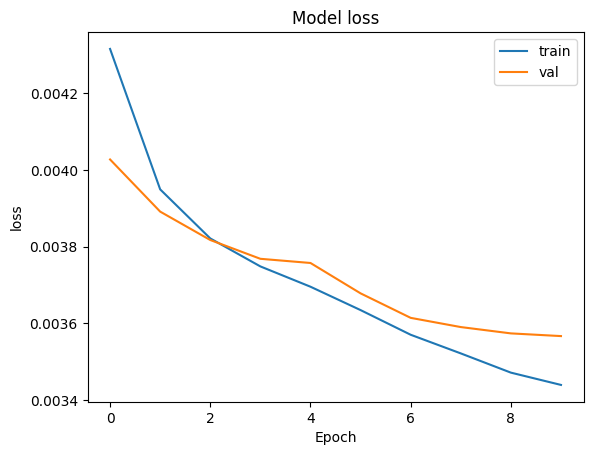

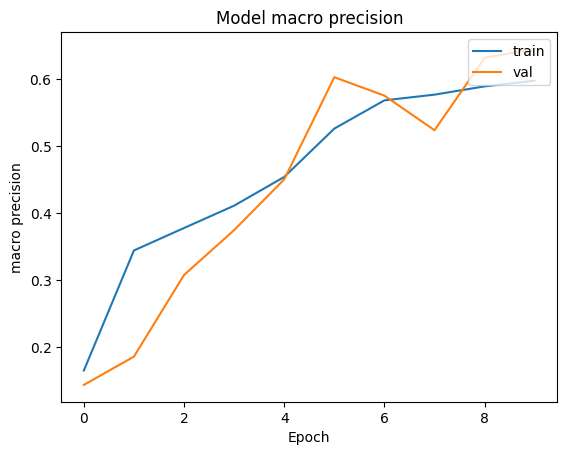

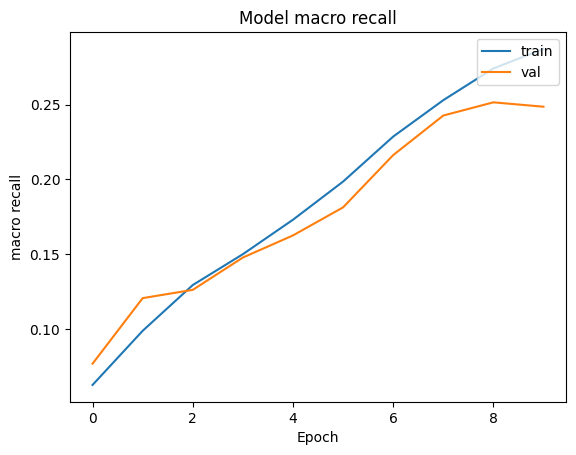

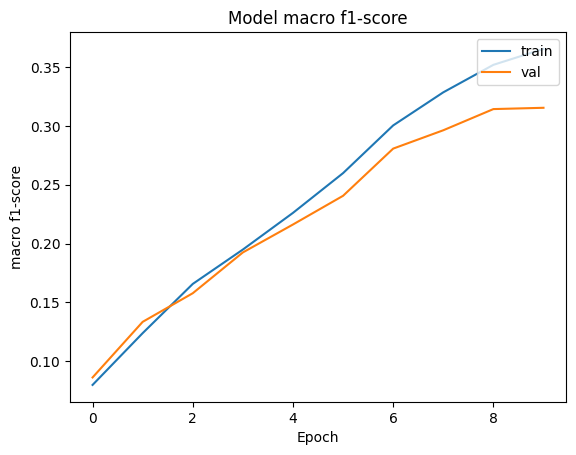

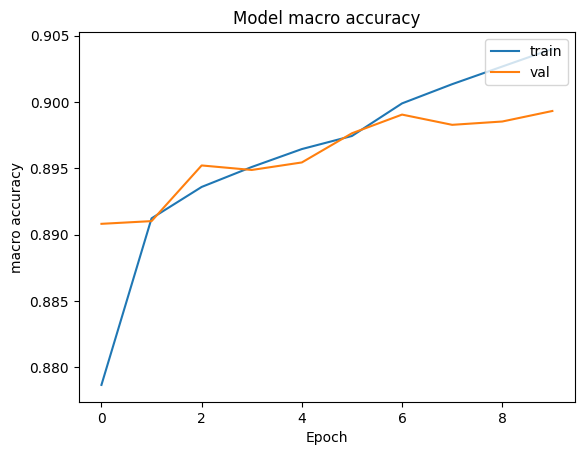

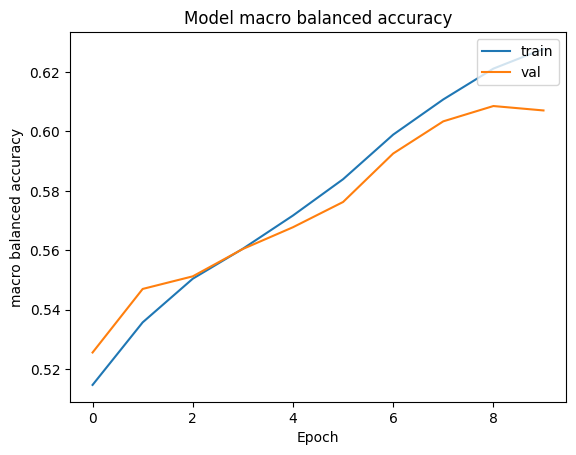

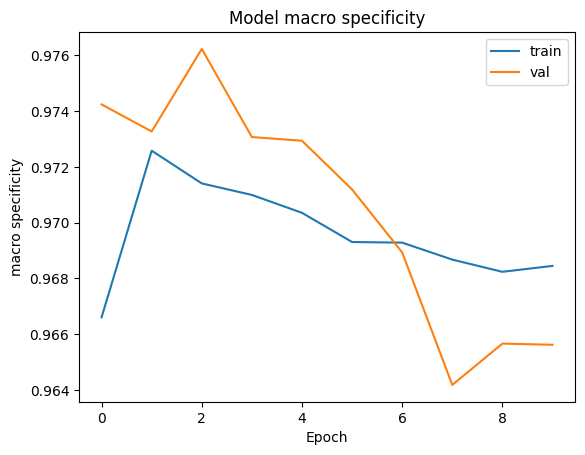

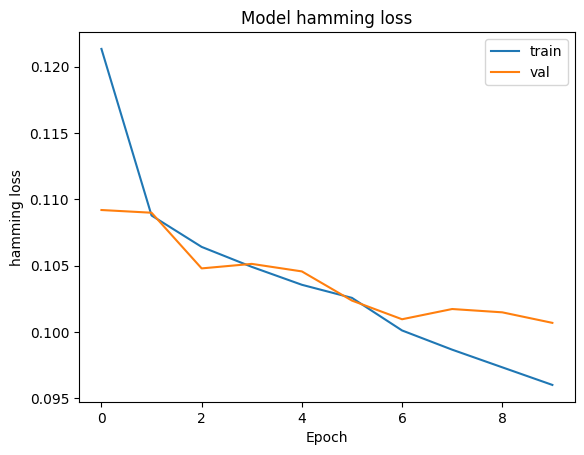

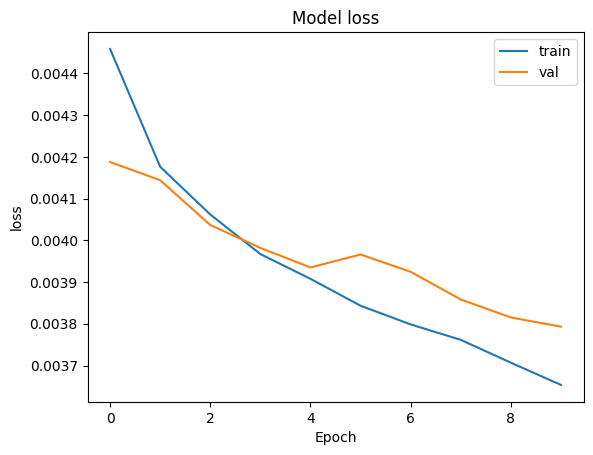

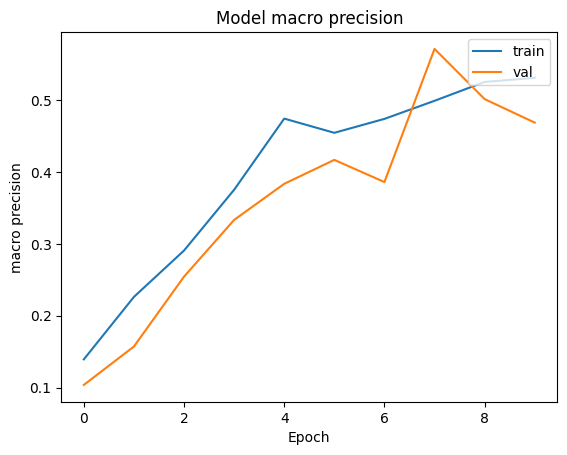

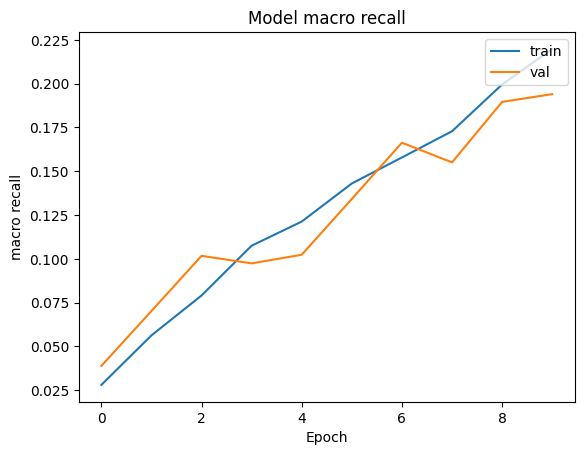

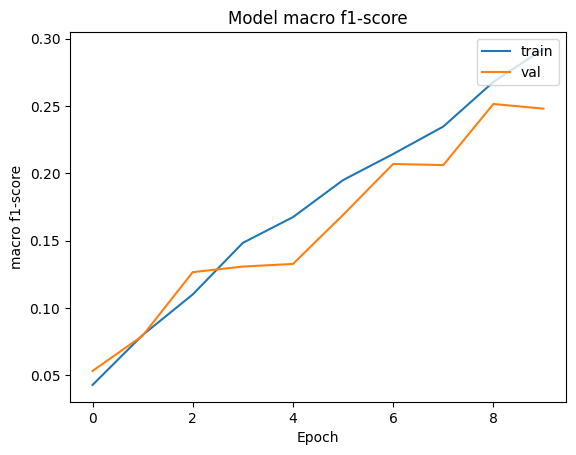

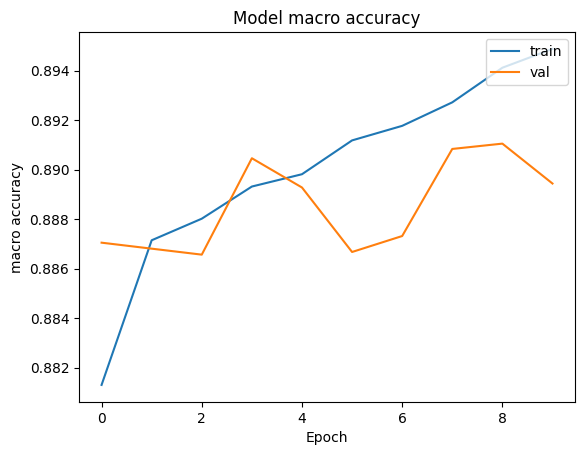

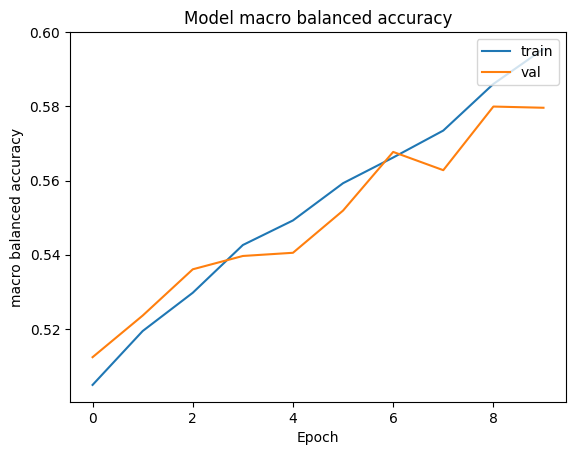

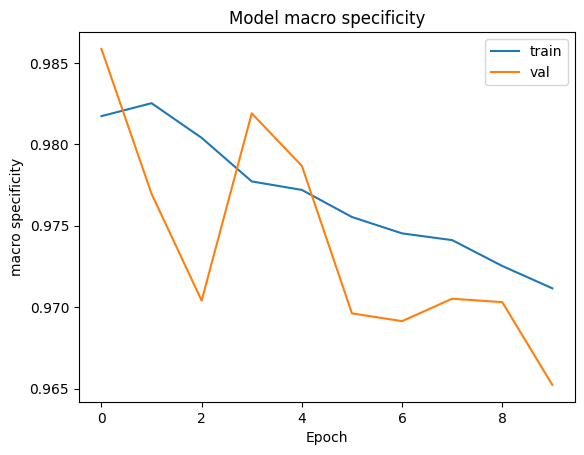

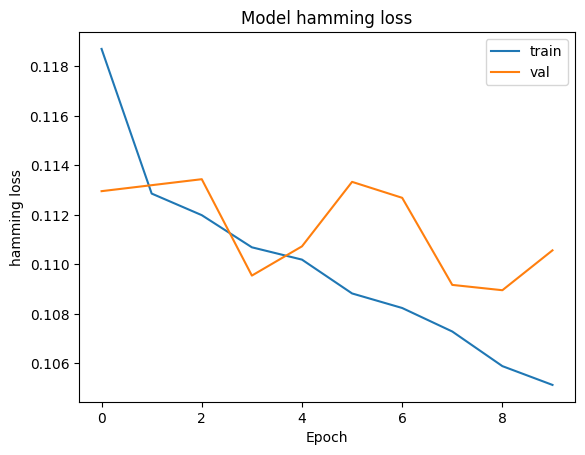

In [30]:
level_2_trainer.run()

In [31]:
fiction_checkpoint_dir

'./checkpoints/BLIP/level_2_/fiction'

In [37]:
from Tester_1 import Tester_level_2

In [38]:
tester_level_2 = Tester_level_2(
    level_1_model = model_level_1,
    level_2_pre_model = level_2_pre_model,
    fiction_model = fiction_model,
    non_fiction_model = non_fiction_model,
    weights_file = level_1_model_file,
    data_loader = test_dataloader,
    fiction_checkpoint_dir = './checkpoints/BLIP/level_2_/fiction',
    non_fiction_checkpoint_dir = './checkpoints/BLIP/level_2_/non_fiction',
    fiction_gamma_pos = fiction_gamma_pos,
    fiction_gamma_neg = fiction_gamma_neg,
    non_fiction_gamma_pos = non_fiction_gamma_pos,
    non_fiction_gamma_neg = non_fiction_gamma_neg
)


fiction weights are loaded
non fiction weights are loaded


In [39]:
tester_level_2.prediction()

started prediction
2024-06-10 23:43:34.585413


100%|██████████████████████████| 49/49 [04:26<00:00,  5.45s/batch, loss=0.00355]
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

LOSS test 0.0034810462966561317, test_precision 0.6566530257061356, test_recall 0.25097681667552285, test_f1 0.32456253433550275, test_accuracy 0.9011047874121184, test_BA 0.6093946310623001, test_specificity 0.9678124454490771, test_hamming_loss 0.09889521258788016
acc [0.92168285 0.86343042 0.96569579 0.87184466 0.9605178  0.96699029
 0.94886731 0.98576052 0.94174757 0.94757282 0.90485437 0.95857605
 0.79805825 0.90226537 0.8763754  0.65954693 0.70032362 0.94368932
 0.95339806 0.89967638 0.97087379 0.9631068  0.85501618 0.9579288
 0.96634304 0.94304207 0.81229773 0.95469256 0.73786408]
precision [0.63333333 0.67630058 1.         0.71910112 0.65853659 0.7826087
 0.6        0.97222222 0.875      0.         0.66666667 0.9
 0.56074766 0.72727273 0.71052632 0.66885965 0.49752475 0.77272727
 0.64814815 0.80597015 0.5        0.91666667 0.65822785 0.66666667
 0.89473684 0.46666667 0.45625    0.         0.60817717]
recall [0.14728682 0.43014706 0.07017544 0.72316384 0.36486486 0.28125
 0.0740

100%|██████████████████████████| 40/40 [05:15<00:00,  7.89s/batch, loss=0.00359]

LOSS test 0.0036854869686067104, test_precision 0.5257442336964019, test_recall 0.19918218544538924, test_f1 0.2587220119862605, test_accuracy 0.893823657791357, test_BA 0.583106294285765, test_specificity 0.9670304031261412, test_hamming_loss 0.10617634220864201
acc [0.94936709 0.8710443  0.93987342 0.92642405 0.95174051 0.95332278
 0.95411392 0.96202532 0.92721519 0.92325949 0.92246835 0.9153481
 0.69541139 0.66376582 0.89952532 0.87183544 0.92088608 0.92325949
 0.93433544 0.90427215 0.92405063 0.77768987 0.9335443  0.83148734
 0.88370253 0.96123418 0.9335443  0.92246835 0.74367089]
precision [0.67647059 0.57894737 0.4        0.54878049 0.8627451  0.38461538
 0.         0.57894737 0.48484848 0.66666667 0.83333333 0.625
 0.51383399 0.46857143 0.4516129  0.61290323 0.35714286 0.
 0.7826087  0.63636364 0.38       0.63888889 0.65625    0.44927536
 0.61607143 0.5        0.39130435 0.63636364 0.51503759]
recall [0.52272727 0.13017751 0.08219178 0.44554455 0.44897959 0.08928571
 0.         


/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/prolay/anaconda3/envs/torch_2.1.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{